# DSC preprocessing:

Divideremo questa pipeline in 4 parti:
1) Primo sguardo ai dati di buffer vs buffer:
2) Primo sguardo ai segnali del campione;
3) Normalizzazione dei dati;
4) Sottrazione del buffer e confronto tra i segnali del sample;
5) Ricerca baseline.

## Primo sguardo (Buffer):
Caricamento dei dati buffer vs buffer e confronto qualitativo tra scan.

Per prima cosa è importante e consigliabile dare uno sguardo ai dati dei buffer, confrontandoli qualitativamente grazie ai dei plot. I dati sono stati esportati dal programma 'nanoAnalyze' fortino insieme allo strumento 'NanocalorimetroTa (nanoDSC TA)'.
Li carichiamo con pandas:

In [2]:
import pandas as pd
import os

folder_path = r"/Users/marco/Desktop/TESI/LOCAL_P/c-MYC/DSC/Dati"

buffer_dataframes = {}

for file in os.listdir(folder_path):
    # Filtra solo i file che iniziano con "buffer" (puoi anche usare: if file.lower().startswith("buffer"))
    if file.endswith(".dat") and file.lower().startswith("buffer"):
        file_full_path = os.path.join(folder_path, file)
        try:
            df = pd.read_csv(file_full_path, sep='\t', header=None, encoding='utf-16')

            buffer_dataframes[file] = df
        except Exception as e:
            print(f"Errore nel file {file}: {e}")

print("File buffer caricati correttamente:")
for name in buffer_dataframes:
    print("-", name)


File buffer caricati correttamente:
- buffer_20mmk-fos_70kcl_190525scan1.dat
- buffer_20mmk-fos_70kcl_190525scan2.dat
- buffer_20mmk-fos_70kcl_190525scan3.dat
- buffer_20mmk-fos_70kcl_190525scan5.dat
- buffer_20mmk-fos_70kcl_270525scan1.dat
- buffer_20mmk-fos_70kcl_270525scan2.dat
- buffer_20mmk-fos_70kcl_270525scan3.dat
- buffer_20mmk-fos_70kcl_270525scan4.dat
- buffer_20mmk-fos_70kcl_270525scan5.dat
- buffer_20mmk-fos_70kcl_270525scan6.dat
- buffer_20mmk-fos_70kcl_290525scan1.dat
- buffer_20mmk-fos_70kcl_290525scan2.dat
- buffer_20mmk-fos_70kcl_290525scan3.dat
- buffer_20mmk-fos_70kcl_290525scan4.dat
- buffer_20mmk-fos_70kcl_290525scan5.dat
- buffer_20mmk-fos_70kcl_290525scan6.dat


Diamo uno sguardo ai singoli dataframe per capirne la forma (il primo ad esempio):


In [3]:
# Ottieni la chiave (nome del file) del primo buffer caricato
first_file = list(buffer_dataframes.keys())[0]

# Estrai il dataframe corrispondente
df = buffer_dataframes[first_file]

# Mostra il nome e le prime righe
print(f"Primo file caricato: {first_file}")
df.head()

Primo file caricato: buffer_20mmk-fos_70kcl_190525scan1.dat


,0,1,2,3
0,Raw data,1,"20,002","-18,197"
1,Raw data,2,"20,017","-18,163"
2,Raw data,3,"20,042","-18,969"
3,Raw data,4,"20,075","-19,817"
4,Raw data,5,"20,114","-20,603"


Puliamo le prime due colonne:

In [4]:
for name, df in buffer_dataframes.items():
    if df.shape[1] < 4:
        print(f" Skipping {name}: only {df.shape[1]} columns")
        continue

    try:
        # Estrai le due colonne e copia per sicurezza
        df_clean = df.iloc[:, [2, 3]].copy()
        df_clean.columns = ["Temperatura", "Cp"]

        # Pulisci le virgole e converti in float
        df_clean["Temperatura"] = df_clean["Temperatura"].astype(str).str.replace(",", ".").astype(float)
        df_clean["Cp"] = df_clean["Cp"].astype(str).str.replace(",", ".").astype(float)

        # Salva nel dizionario
        buffer_dataframes[name] = df_clean

    except Exception as e:
        print(f" Errore nel file {name}: {e}")


Creiamo un dizionario con nomi più semplici $ b_i $ e stampiamo le prime 5 righe di uno casualmente.

In [5]:
buffer_dataframes_renamed = {}

for i, (old_name, df) in enumerate(buffer_dataframes.items(), start=1):
    new_name = f"b{i}"
    buffer_dataframes_renamed[new_name] = df

buffer_dataframes_renamed["b4"].head()

,Temperatura,Cp
0,99.816,5.306
1,99.802,5.353
2,99.782,5.387
3,99.756,5.861
4,99.726,6.388


In [6]:
for name, df in buffer_dataframes_renamed.items():
    buffer_dataframes_renamed[name] = df.sort_values(by="Temperatura")

for name, df in buffer_dataframes_renamed.items():
    print(f"{name}: T min = {df['Temperatura'].min()}, T max = {df['Temperatura'].max()}, ordinata? {df['Temperatura'].is_monotonic_increasing}")


b1: T min = 20.002, T max = 99.999, ordinata? True
b2: T min = 20.0, T max = 99.815, ordinata? True
b3: T min = 20.003, T max = 99.974, ordinata? True
b4: T min = 20.015, T max = 99.816, ordinata? True
b5: T min = 20.002, T max = 99.983, ordinata? True
b6: T min = 20.009, T max = 99.868, ordinata? True
b7: T min = 20.003, T max = 99.991, ordinata? True
b8: T min = 20.024, T max = 99.815, ordinata? True
b9: T min = 20.003, T max = 99.985, ordinata? True
b10: T min = 20.032, T max = 99.812, ordinata? True
b11: T min = 20.002, T max = 119.975, ordinata? True
b12: T min = 20.031, T max = 119.87, ordinata? True
b13: T min = 20.003, T max = 120.002, ordinata? True
b14: T min = 20.021, T max = 119.789, ordinata? True
b15: T min = 20.003, T max = 119.973, ordinata? True
b16: T min = 20.008, T max = 119.792, ordinata? True


Ora possiamo plottare i dati dei buffer per fare un confronto visivo:
Questa sezione genera una griglia di sottografici che visualizzano tutte le curve dei file `buffer`, già rinominati.

- Ogni grafico mostra l'andamento del calore specifico `Cp` in funzione della **temperatura**.
- Le curve vengono suddivise in una griglia con 2 colonne.
- I titoli generali "Andata" e "Ritorno" aiutano a distinguere visivamente i due tipi di scansione, assumendo che siano ordinati nel dizionario.

Eventuali assi vuoti vengono automaticamente rimossi per rendere il layout più pulito.

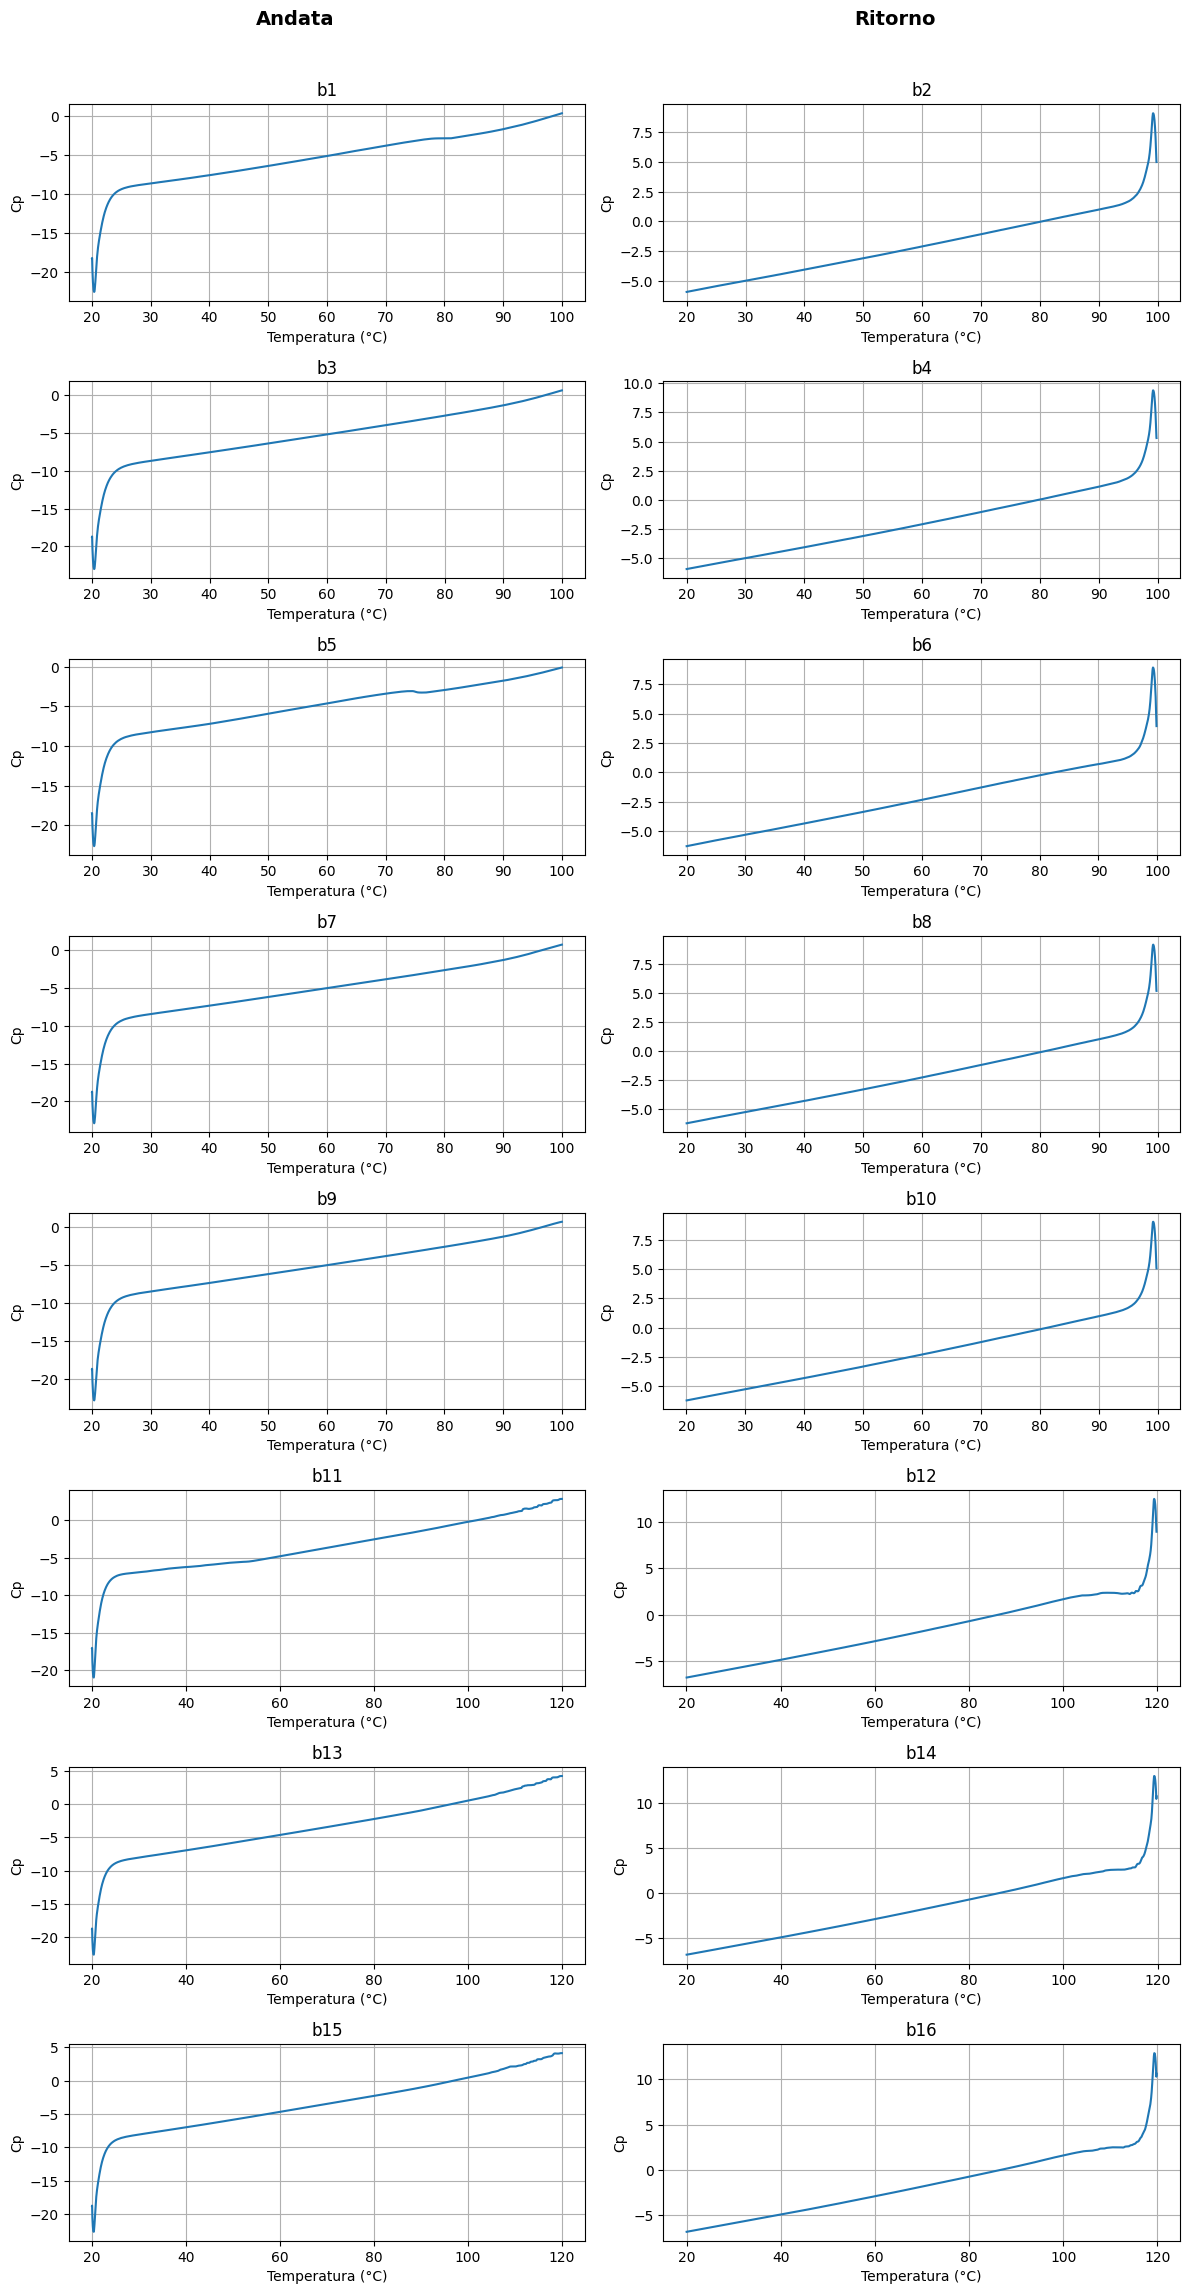

In [7]:
import matplotlib.pyplot as plt
import math

# Numero totale di dataset
n_plot = len(buffer_dataframes_renamed)
n_cols = 2
n_rows = math.ceil(n_plot / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()

for i, (name, df) in enumerate(buffer_dataframes_renamed.items()):
    ax = axes[i]
    ax.plot(df["Temperatura"], df["Cp"])
    ax.set_title(name)
    ax.set_xlabel("Temperatura (°C)")
    ax.set_ylabel("Cp")
    ax.grid(True)

# Nasconde eventuali assi vuoti
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.text(0.25, 0.95, "Andata", ha='center', va='center', fontsize=14, weight='bold')
fig.text(0.75, 0.95, "Ritorno", ha='center', va='center', fontsize=14, weight='bold')


plt.tight_layout(rect=[0, 0, 1, 0.93])  # lascia spazio sopra per i sottotitoli
plt.show()


E' evidente che i plot di andata e ritorno sono differenti, in quanto nei grafici di sx il buffer viene riscaldato da 20 a 100°C nel nanoDSC, su quelli di dx, invece, viene raffreddato da 100 a 20°C.
Ancora da capire perché.

Per un confronto più approfondito si è scelto di plottare i dati di baffer in un singolo grafico, nella cella sottostante si possono notare gli scan di andata, in quella successiva il ritorno.

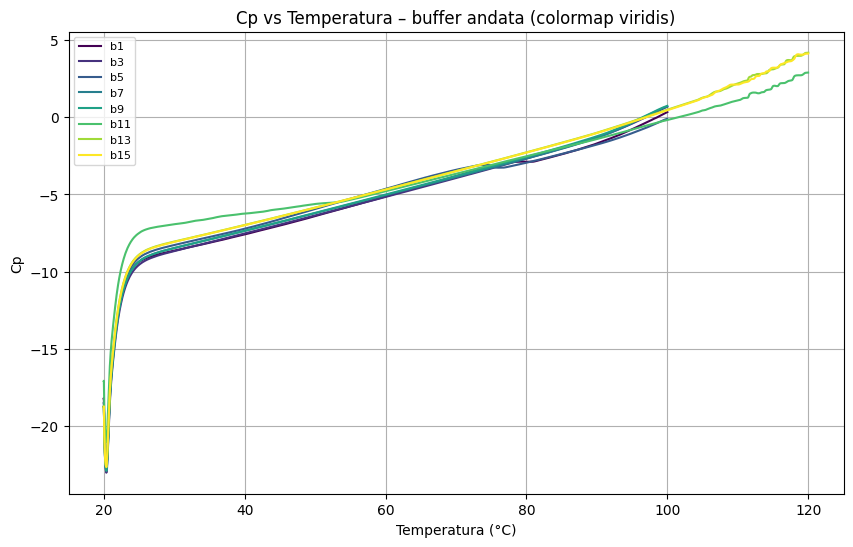

In [8]:
import matplotlib.cm as cm
import numpy as np

# Filtra solo i b dispari
curve_names = [name for name in buffer_dataframes_renamed if int(name[1:]) % 2 == 1]
n = len(curve_names)

# Colori dalla colormap 'viridis'
colors = cm.viridis(np.linspace(0, 1, n))

plt.figure(figsize=(10, 6))

for i, name in enumerate(curve_names):
    df = buffer_dataframes_renamed[name]
    plt.plot(df["Temperatura"], df["Cp"], label=name, color=colors[i])

plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp")
plt.title("Cp vs Temperatura – buffer andata (colormap viridis)")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()


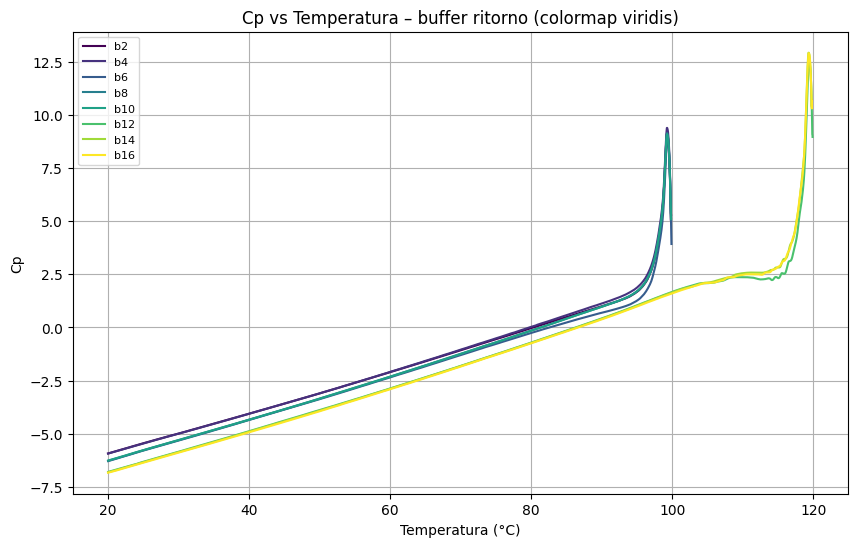

In [9]:
# Filtra solo i b pari
curve_names = [name for name in buffer_dataframes_renamed if int(name[1:]) % 2 == 0]
n = len(curve_names)

# Colori dalla colormap 'viridis'
colors = cm.viridis(np.linspace(0, 1, n))

plt.figure(figsize=(10, 6))

for i, name in enumerate(curve_names):
    df = buffer_dataframes_renamed[name]
    plt.plot(df["Temperatura"], df["Cp"], label=name, color=colors[i])

plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp")
plt.title("Cp vs Temperatura – buffer ritorno (colormap viridis)")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()


Dando un primo sguardo ai dati si notano delle anomalie nel primo run (scan) di tutte le prese dati per i buffer, in particolare:

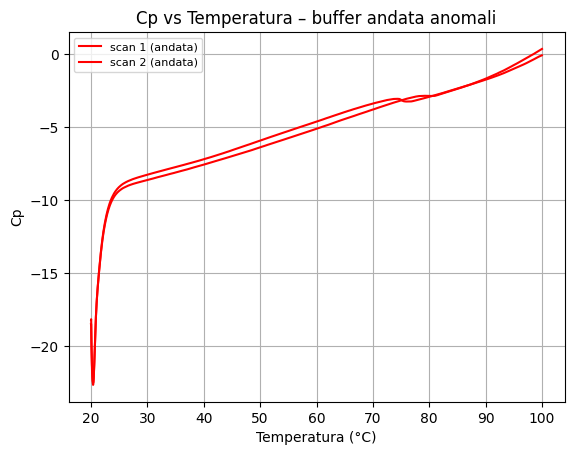

In [10]:
plt.Figure(figsize=(10, 6))
plt.plot(buffer_dataframes_renamed["b1"]["Temperatura"], buffer_dataframes_renamed["b1"]["Cp"], label="scan 1 (andata)", color="red")
plt.plot(buffer_dataframes_renamed["b5"]["Temperatura"], buffer_dataframes_renamed["b5"]["Cp"], label="scan 2 (andata)", color="red")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp")
plt.title("Cp vs Temperatura – buffer andata anomali")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

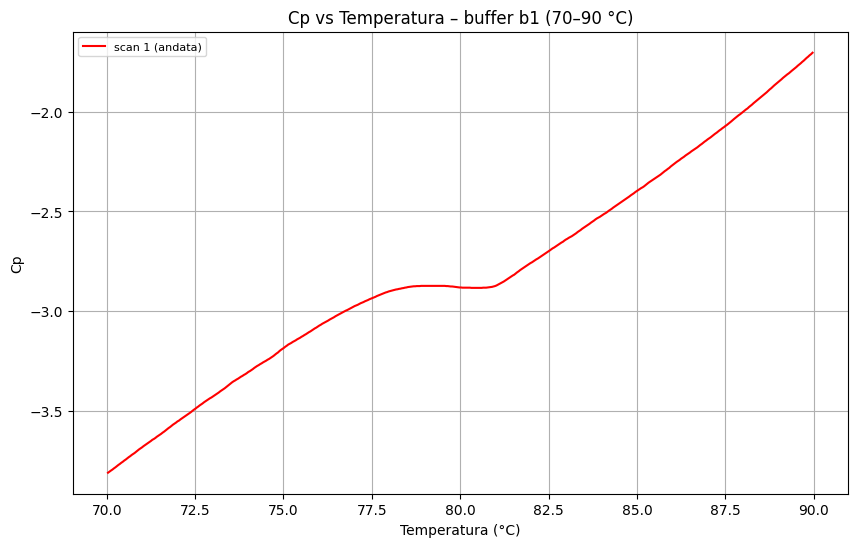

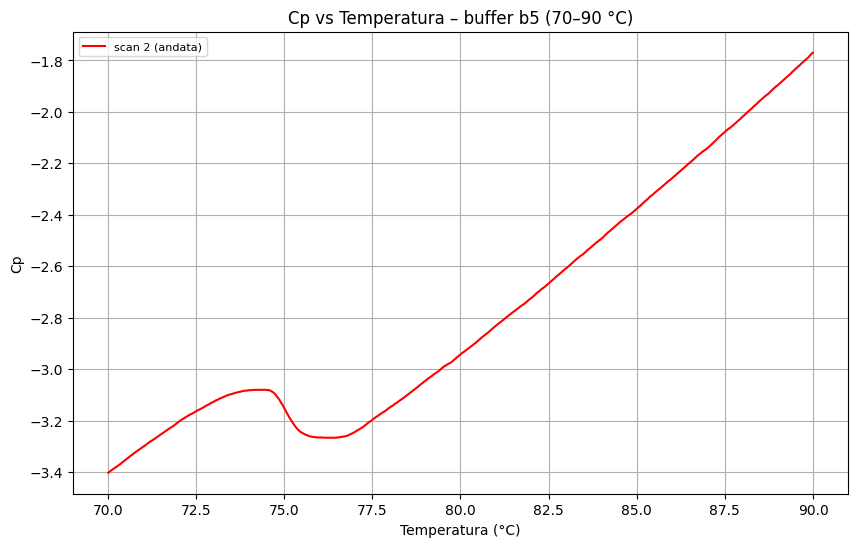

In [11]:
# Maschera da 70 a 90 °C
T_min, T_max = 70, 90

# ----------- b1 -----------
df1 = buffer_dataframes_renamed["b1"]
mask1 = (df1["Temperatura"] >= T_min) & (df1["Temperatura"] <= T_max)
df1_masked = df1[mask1]

plt.figure(figsize=(10, 6))
plt.plot(df1_masked["Temperatura"], df1_masked["Cp"], label="scan 1 (andata)", color="red")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp")
plt.title("Cp vs Temperatura – buffer b1 (70–90 °C)")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

# ----------- b5 -----------
df5 = buffer_dataframes_renamed["b5"]
mask5 = (df5["Temperatura"] >= T_min) & (df5["Temperatura"] <= T_max)
df5_masked = df5[mask5]

plt.figure(figsize=(10, 6))
plt.plot(df5_masked["Temperatura"], df5_masked["Cp"], label="scan 2 (andata)", color="red")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp")
plt.title("Cp vs Temperatura – buffer b5 (70–90 °C)")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

Anche qui da capire perché fanno questo lavoro

## Primo sguardo (Sample):
Caricamento dei dati sample vs buffer e confronto qualitativo tra scan

Questa seconda parte ripete esattamente gli stessi step della sezione **Primo sguardo (Buffer)**, non sarà, pertanto, commentata dettagliatamente.

In [12]:
folder_path = r"/Users/marco/Desktop/TESI/LOCAL_P/c-MYC/DSC/Dati"

cmyc_dataframes = {}

for file in os.listdir(folder_path):
    # Filtra solo i file che iniziano con "cmyc" e finiscono con .dat
    if file.endswith(".dat") and file.lower().startswith("cmyc"):
        file_full_path = os.path.join(folder_path, file)
        try:
            df = pd.read_csv(file_full_path, sep='\t', header=None, encoding='utf-16')
            cmyc_dataframes[file] = df
        except Exception as e:
            print(f"Errore nel file {file}: {e}")

print("File cmyc caricati correttamente:")
for name in cmyc_dataframes:
    print("-", name)


File cmyc caricati correttamente:
- cmyc_45um_buffer_20mmk-fos_70kcl_280525scan1.dat
- cmyc_45um_buffer_20mmk-fos_70kcl_280525scan2.dat
- cmyc_45um_buffer_20mmk-fos_70kcl_280525scan3.dat
- cmyc_45um_buffer_20mmk-fos_70kcl_280525scan4.dat
- cmyc_45um_buffer_20mmk-fos_70kcl_280525scan5.dat
- cmyc_45um_buffer_20mmk-fos_70kcl_280525scan6.dat
- cmyc_45um_buffer_20mmk-fos_70kcl_280525scan7.dat
- cmyc_45um_buffer_20mmk-fos_70kcl_280525scan8.dat


In [13]:
# Ottieni la chiave (nome del file) del primo buffer caricato
first_file = list(cmyc_dataframes.keys())[0]

# Estrai il dataframe corrispondente
df_sample = cmyc_dataframes[first_file]

# Mostra il nome e le prime righe
print(f"Primo file caricato: {first_file}")
df_sample.head()

Primo file caricato: cmyc_45um_buffer_20mmk-fos_70kcl_280525scan1.dat


,0,1,2,3
0,Raw data,1,"20,002","-18,639"
1,Raw data,2,"20,018","-18,627"
2,Raw data,3,"20,043","-19,440"
3,Raw data,4,"20,076","-20,283"
4,Raw data,5,"20,123","-21,188"


Plottiamo i dati in due colonne

In [14]:
for name, df in cmyc_dataframes.items():
    if df.shape[1] < 4:
        print(f" Skipping {name}: only {df.shape[1]} columns")
        continue

    try:
        # Estrai le due colonne e copia per sicurezza
        df_sample_clean = df.iloc[:, [2, 3]].copy()
        df_sample_clean.columns = ["Temperatura", "Cp"]

        # Pulisci le virgole e converti in float
        df_sample_clean["Temperatura"] = df_sample_clean["Temperatura"].astype(str).str.replace(",", ".").astype(float)
        df_sample_clean["Cp"] = df_sample_clean["Cp"].astype(str).str.replace(",", ".").astype(float)

        # Salva nel dizionario
        cmyc_dataframes[name] = df_sample_clean

    except Exception as e:
        print(f" Errore nel file {name}: {e}")


Creiamo un dataframe con nomi più semplici al fine di gestire andate e eritorni degli scan ($c_i$).

In [15]:
cmyc_dataframes_renamed = {}

for i, (old_name, df) in enumerate(cmyc_dataframes.items(), start=1):
    new_name = f"c{i}"
    cmyc_dataframes_renamed[new_name] = df

cmyc_dataframes_renamed["c4"].head()

,Temperatura,Cp
0,119.788,11.264
1,119.774,11.169
2,119.755,10.914
3,119.730,11.196
4,119.702,11.559


Ordiniamo i dati (T).

In [16]:
for name, df in cmyc_dataframes_renamed.items():
    cmyc_dataframes_renamed[name] = df.sort_values(by="Temperatura")

for name, df in cmyc_dataframes_renamed.items():
    print(f"{name}: T min = {df['Temperatura'].min()}, T max = {df['Temperatura'].max()}, ordinata? {df['Temperatura'].is_monotonic_increasing}")


c1: T min = 20.002, T max = 119.981, ordinata? True
c2: T min = 20.018, T max = 119.792, ordinata? True
c3: T min = 20.003, T max = 119.992, ordinata? True
c4: T min = 20.016, T max = 119.788, ordinata? True
c5: T min = 20.003, T max = 120.008, ordinata? True
c6: T min = 19.998, T max = 119.793, ordinata? True
c7: T min = 20.003, T max = 119.981, ordinata? True
c8: T min = 20.019, T max = 119.792, ordinata? True


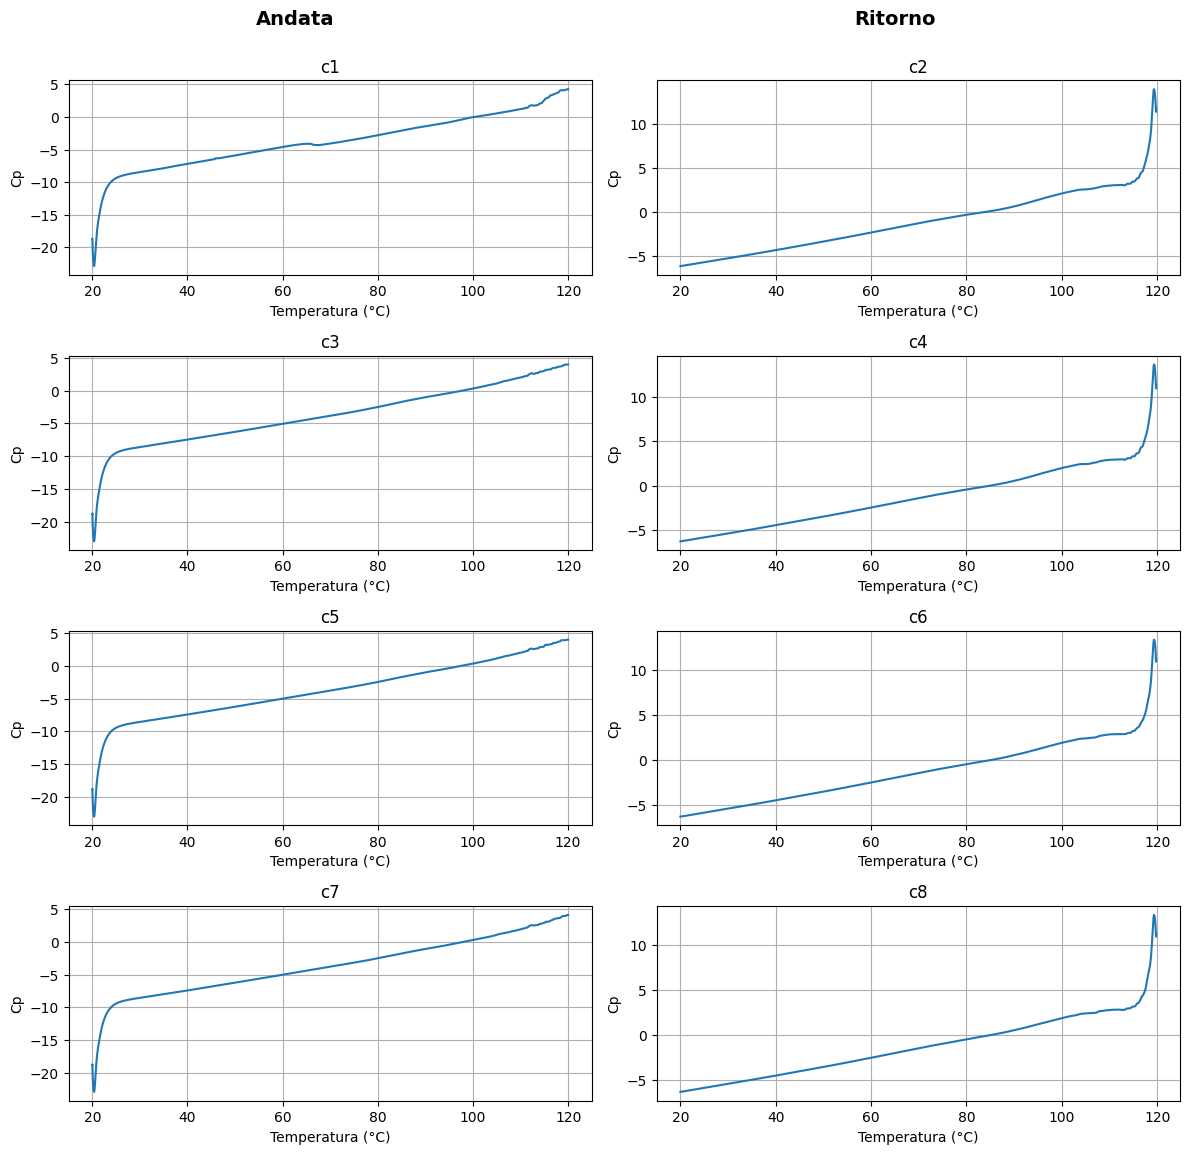

In [17]:
# Numero totale di dataset
n_plot = len(cmyc_dataframes_renamed)
n_cols = 2
n_rows = math.ceil(n_plot / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()

for i, (name, df) in enumerate(cmyc_dataframes_renamed.items()):
    ax = axes[i]
    ax.plot(df["Temperatura"], df["Cp"])
    ax.set_title(name)
    ax.set_xlabel("Temperatura (°C)")
    ax.set_ylabel("Cp")
    ax.grid(True)

# Nasconde eventuali assi vuoti
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.text(0.25, 0.95, "Andata", ha='center', va='center', fontsize=14, weight='bold')
fig.text(0.75, 0.95, "Ritorno", ha='center', va='center', fontsize=14, weight='bold')


plt.tight_layout(rect=[0, 0, 1, 0.93])  # lascia spazio sopra per i sottotitoli
plt.show()


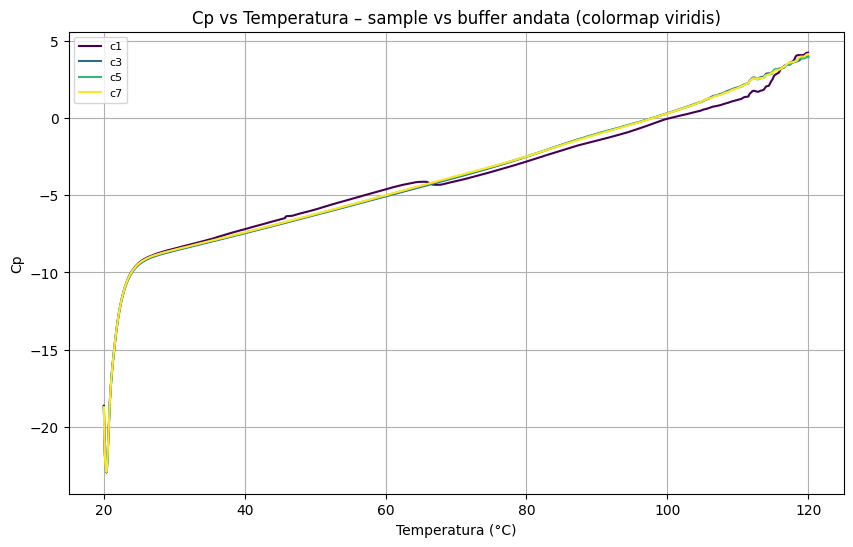

In [18]:
# Filtra solo i b dispari
curve_names = [name for name in cmyc_dataframes_renamed if int(name[1:]) % 2 == 1]
n = len(curve_names)

# Colori dalla colormap 'viridis'
colors = cm.viridis(np.linspace(0, 1, n))

plt.figure(figsize=(10, 6))

for i, name in enumerate(curve_names):
    df = cmyc_dataframes_renamed[name]
    plt.plot(df["Temperatura"], df["Cp"], label=name, color=colors[i])

plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp")
plt.title("Cp vs Temperatura – sample vs buffer andata (colormap viridis)")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()


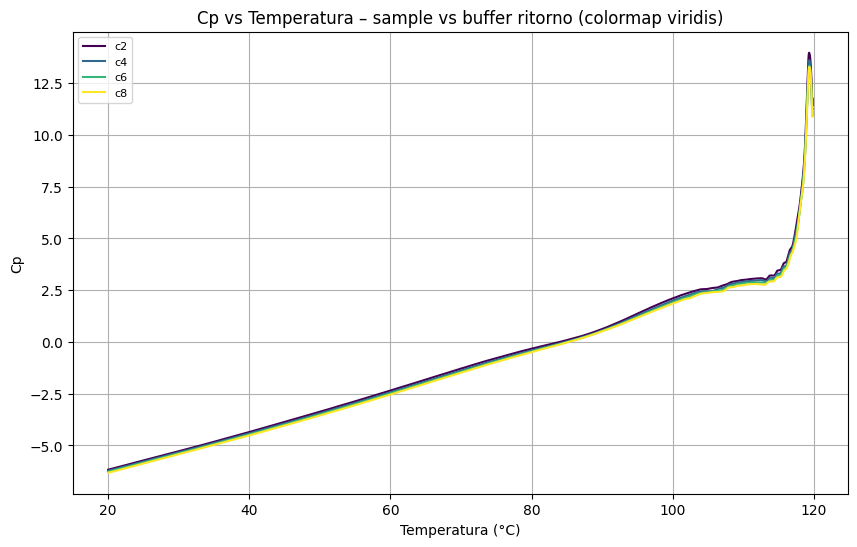

In [19]:
# Filtra solo i b pari
curve_names = [name for name in cmyc_dataframes_renamed if int(name[1:]) % 2 == 0]
n = len(curve_names)

# Colori dalla colormap 'viridis'
colors = cm.viridis(np.linspace(0, 1, n))

plt.figure(figsize=(10, 6))

for i, name in enumerate(curve_names):
    df = cmyc_dataframes_renamed[name]
    plt.plot(df["Temperatura"], df["Cp"], label=name, color=colors[i])

plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp")
plt.title("Cp vs Temperatura – sample vs buffer ritorno (colormap viridis)")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()


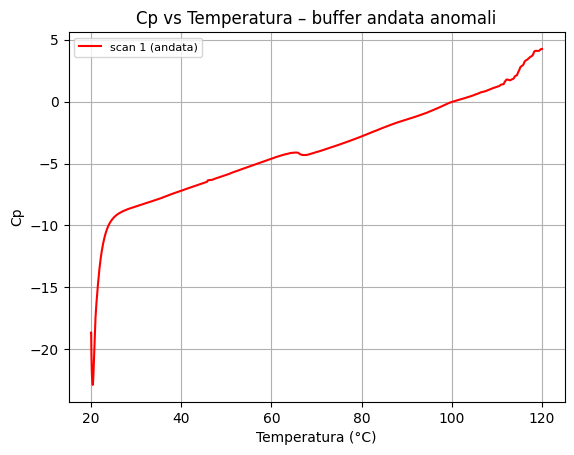

In [20]:
plt.Figure(figsize=(10, 6))
plt.plot(cmyc_dataframes_renamed["c1"]["Temperatura"], cmyc_dataframes_renamed["c1"]["Cp"], label="scan 1 (andata)", color="red")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp")
plt.title("Cp vs Temperatura – buffer andata anomali")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

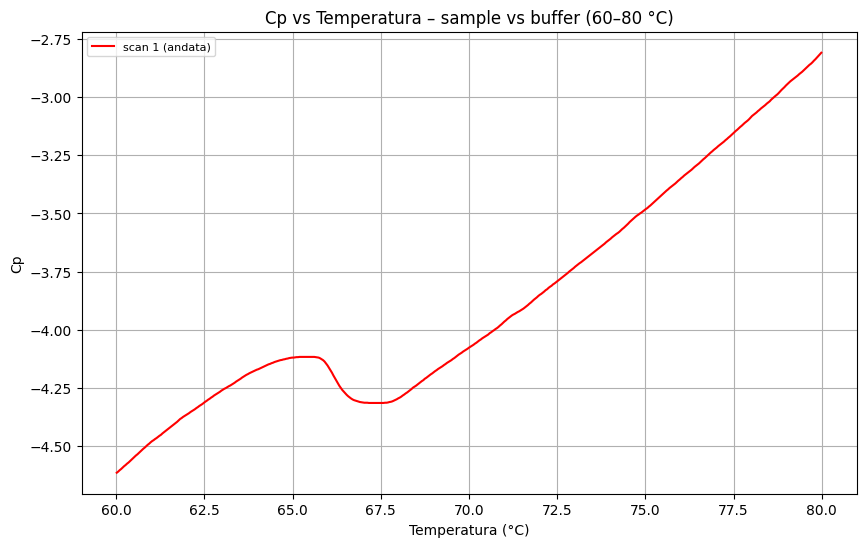

In [21]:
# Maschera da 70 a 90 °C
T_min, T_max = 60, 80

# ----------- c1 -----------
df1_s = cmyc_dataframes_renamed["c1"]
mask1_s = (df1_s["Temperatura"] >= T_min) & (df1_s["Temperatura"] <= T_max)
df1_masked_s = df1_s[mask1_s]

plt.figure(figsize=(10, 6))
plt.plot(df1_masked_s["Temperatura"], df1_masked_s["Cp"], label="scan 1 (andata)", color="red")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp")
plt.title("Cp vs Temperatura – sample vs buffer (60–80 °C)")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

plt.show()

## Estrazione dei segnali del campione:

In questa sezione l'obbiettivo è estrarre i dati grezzi del sample. Non verranno infatti 'puliti' del tutto in quanto a tal fine è necessario sottrarre la baseline.

Quello che verrà fatto è andare a confrontare i scan di buffer vs buffer -> fare una media dei risultati ottenuti -> andare a sottrarre al segnale di sample vs buffer quello di buffer vs buffer.

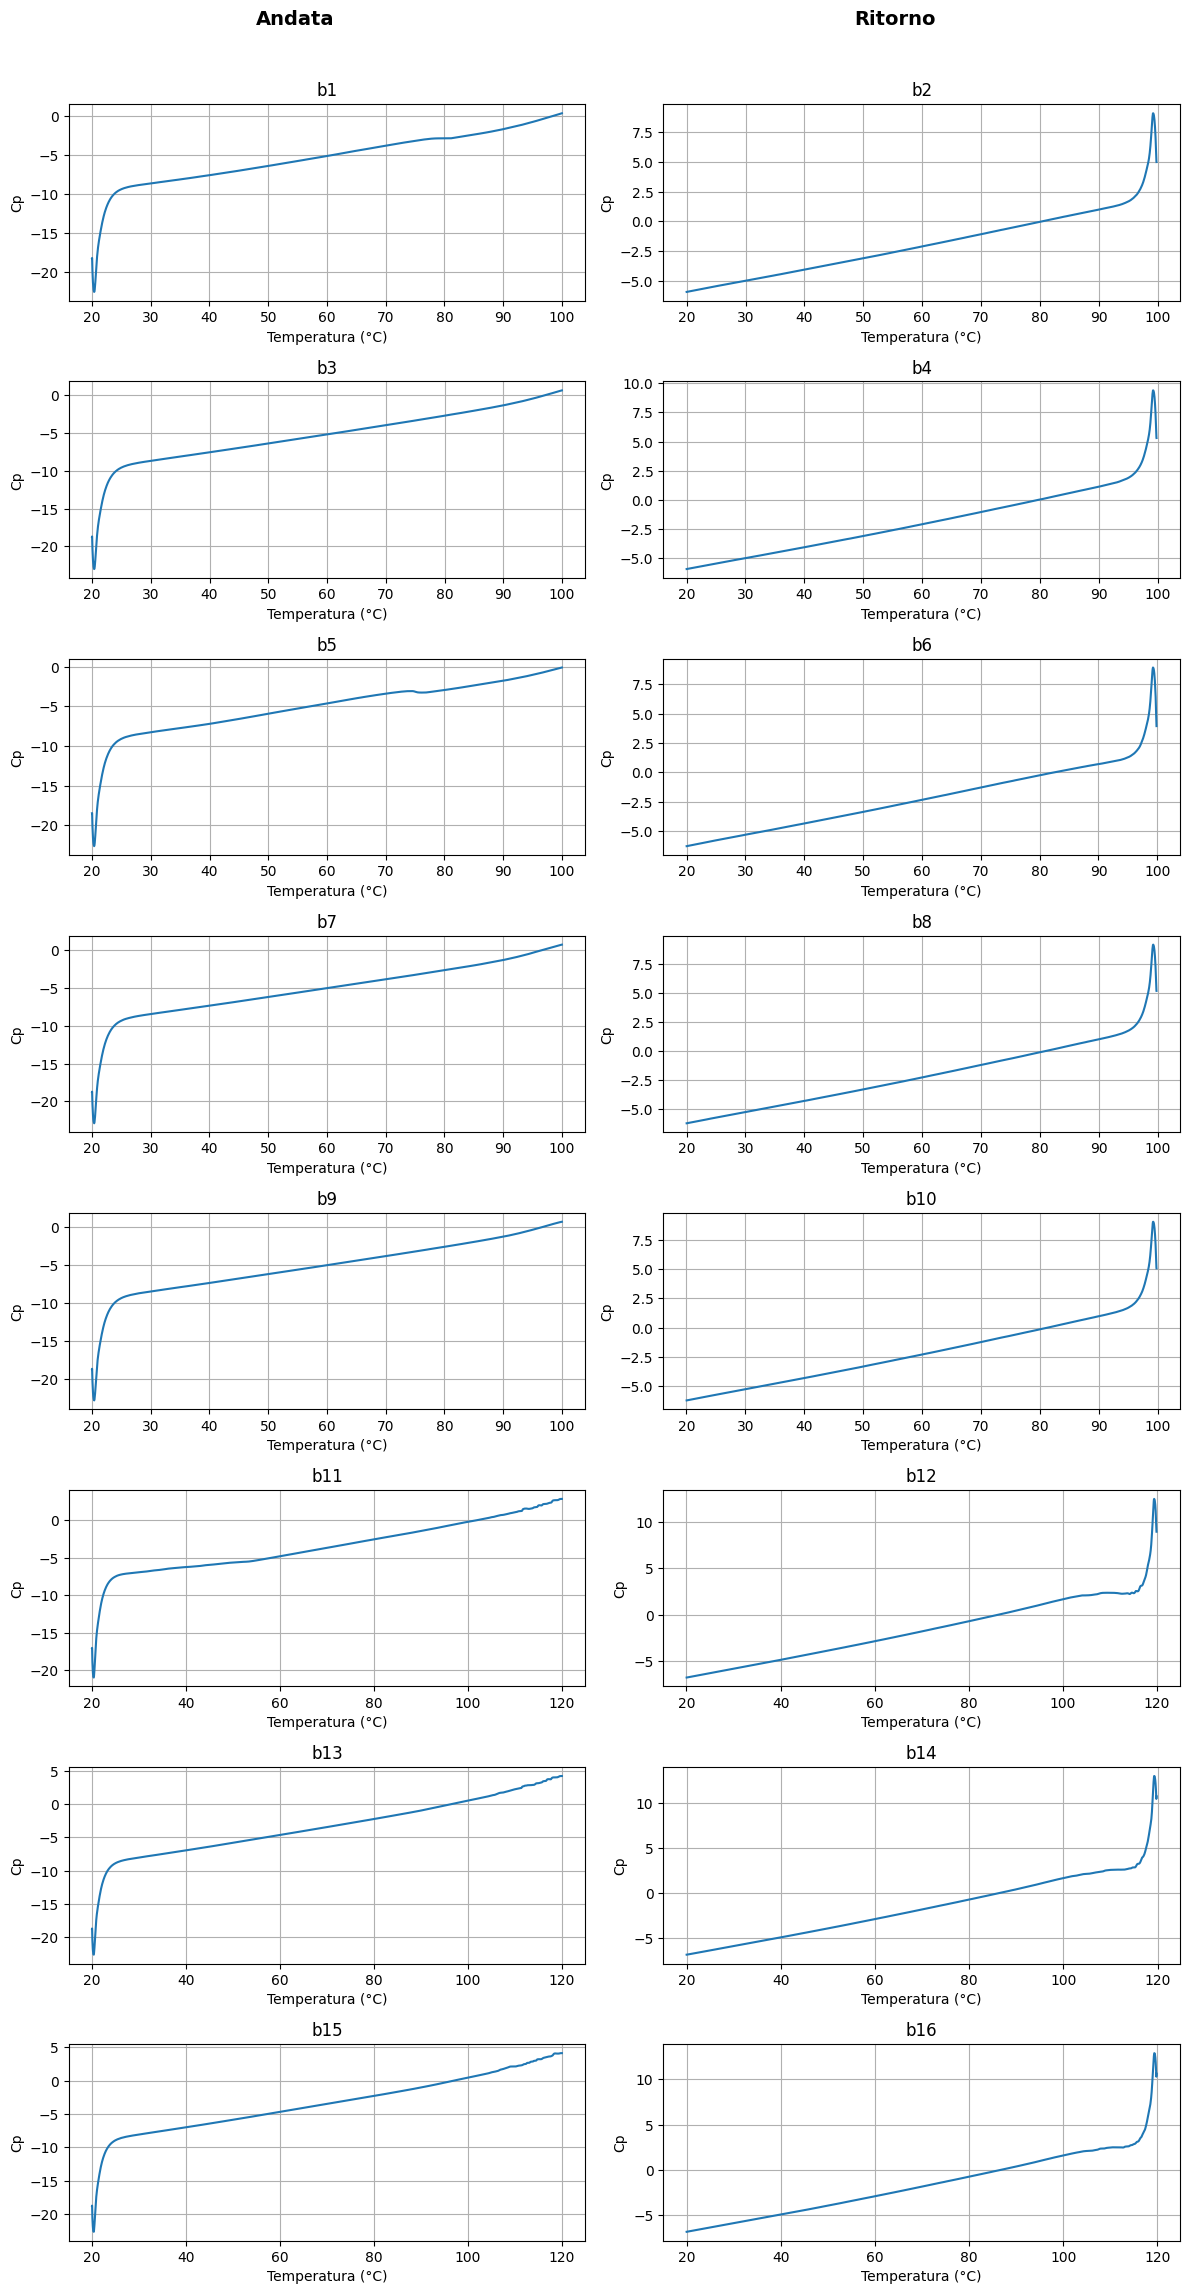

In [22]:
# Calcola layout
n_plot = len(buffer_dataframes_renamed)
n_cols = 2
n_rows = math.ceil(n_plot / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()

for i, (name, df) in enumerate(buffer_dataframes_renamed.items()):
    ax = axes[i]
    ax.plot(df["Temperatura"], df["Cp"], label=name)
    ax.set_title(name)
    ax.set_xlabel("Temperatura (°C)")
    ax.set_ylabel("Cp")
    ax.grid(True)

# Nasconde eventuali assi vuoti
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.text(0.25, 0.95, "Andata", ha='center', va='center', fontsize=14, weight='bold')
fig.text(0.75, 0.95, "Ritorno", ha='center', va='center', fontsize=14, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In questa sezione si calcola la media delle curve DSC ottenute dai file buffer:

- I file con indice **dispari** (b1, b3, …) vengono considerati **di andata**
- I file con indice **pari** (b2, b4, …) vengono considerati **di ritorno**

Tutte le curve vengono interpolate su una **griglia di temperatura comune** per poter effettuare una media punto-punto.

Vengono infine visualizzate tutte le curve dei buffer per un controllo visivo della qualità dei dati.

Al fine di procedere con questa tecnica [CITA SPINK], è necessario andare a confrontare solo i dati derivanti dalla misura effettuata lo stesso giorno in cui vengono presi i dati del sample. Nel caso del campione c-MYC, quindi, i buffer da mediare sono solo quelli rinominati come (nel caso di andata): 

1) $b_5$;
2) $b_7$;
3) $b_9$;
4) $b_{11}$;
5) $b_{13}$;
6) $b_{15}$.

Noto che le anomalie dei dati si presentano ogni qualvolta lo strumento effettua la prima run (misura), è purtroppo necessario scartare ogni primo risultato, sia riguardante il buffer che il campione (in questo caso, quindi non è possibile tenere in considerazione i dati $b_5$ per la media).

Per valutare se questo fenomeno fosse dovuto ad un errore dello strumento o ad un errore della preparazione del buffer si sono valutati due elementi:
1) L'anomalia non risulta ad una temperatura fissa ma si sposta nell'asse delle T per diversi scan indice del fatto che lo strumento fosse pulito;
2) Dato il primo suggerimento si è deciso di fare un'ulteriore serie di run con acqua pulita dove le anomalie non si verificano assicurando che lo strumento funzionasse bene.

Dati questi risulati si è concluso che il problema fosse risalente al buffer: ............

In [23]:
# Griglia comune di temperatura (basata su T di tutti i buffer)
T_min = min(df["Temperatura"].min() for df in buffer_dataframes_renamed.values())
T_max = max(df["Temperatura"].max() for df in buffer_dataframes_renamed.values())
T_common = np.linspace(min(T_min, T_max), max(T_min, T_max), 500)

# Inizializza liste
cp_interp_andata = []
cp_interp_ritorno = []

for name, df in buffer_dataframes_renamed.items():
    suffix_number = int(name[1:])  # estrae numero da "b1", "b2"...

    # Considera solo i dispari da b5 in poi e i pari da b6 in poi
    if (suffix_number % 2 == 1 and suffix_number > 5):  # andata
        lista = cp_interp_andata
    elif (suffix_number % 2 == 0 and suffix_number >= 6):  # ritorno
        lista = cp_interp_ritorno
    else:
        continue  # salta b1-b4 e b2-b4

    T = df["Temperatura"].values
    Cp = df["Cp"].values

    # Ordina
    sort_idx = np.argsort(T)
    T_sorted = T[sort_idx]
    Cp_sorted = Cp[sort_idx]

    # Interpola
    Cp_interp = np.interp(T_common, T_sorted, Cp_sorted)

    lista.append(Cp_interp)

# Calcola le due medie
Cp_media_andata = np.mean(cp_interp_andata, axis=0)
Cp_media_ritorno = np.mean(cp_interp_ritorno, axis=0)

# Crea DataFrame finali
buffer_media_df_andata = pd.DataFrame({
    "Temperatura": T_common,
    "Cp_medio_andata": Cp_media_andata
})

buffer_media_df_ritorno = pd.DataFrame({
    "Temperatura": T_common,
    "Cp_medio_ritorno": Cp_media_ritorno
})

print(f"N. buffer andata inclusi: {len(cp_interp_andata)}")
print(f"N. buffer ritorno inclusi: {len(cp_interp_ritorno)}")

N. buffer andata inclusi: 5
N. buffer ritorno inclusi: 6


In [24]:
if not os.path.exists("buffer_media_andata.csv"):
    buffer_media_df_andata.to_csv("buffer_media_andata.csv", sep='\t', index=False)

if not os.path.exists("buffer_media_ritorno.csv"):
    buffer_media_df_ritorno.to_csv("buffer_media_ritorno.csv", sep='\t', index=False)


Procediamo a salvare i buffer in un file csv dopo averli visualizzati.

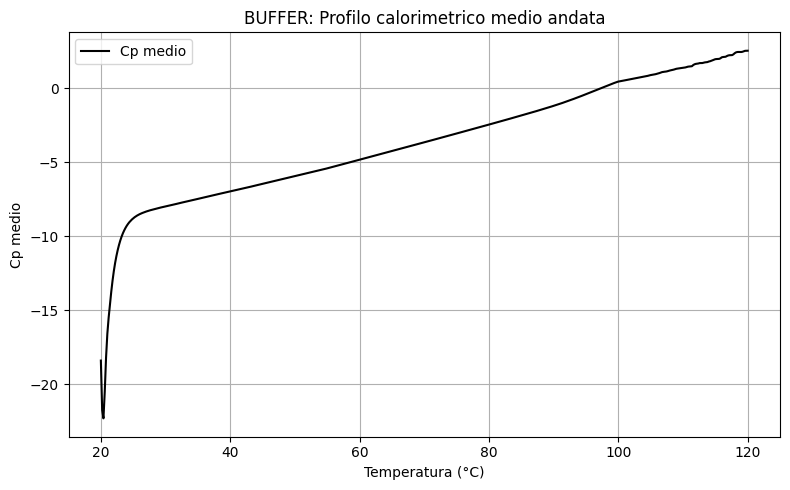

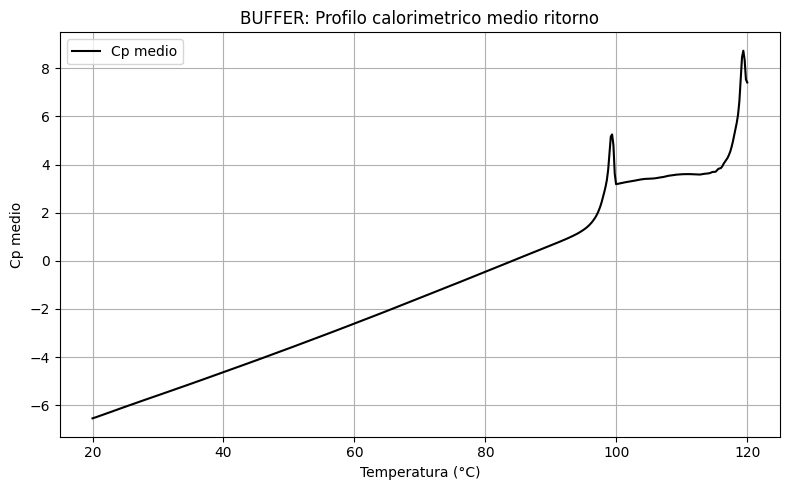

In [25]:
# 1. Plot del buffer medio andata
plt.figure(figsize=(8, 5))
plt.plot(buffer_media_df_andata["Temperatura"], buffer_media_df_andata["Cp_medio_andata"], label="Cp medio", color="black")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp medio")
plt.title("BUFFER: Profilo calorimetrico medio andata")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 2. Plot del buffer medio ritorno
plt.figure(figsize=(8, 5))
plt.plot(buffer_media_df_ritorno["Temperatura"], buffer_media_df_ritorno["Cp_medio_ritorno"], label="Cp medio", color="black")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp medio")
plt.title("BUFFER: Profilo calorimetrico medio ritorno")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Come si nota c'è una deviazione dalla linearità in 100 °C in quanto non tutti i dati sono stati presi fino a 120°C.

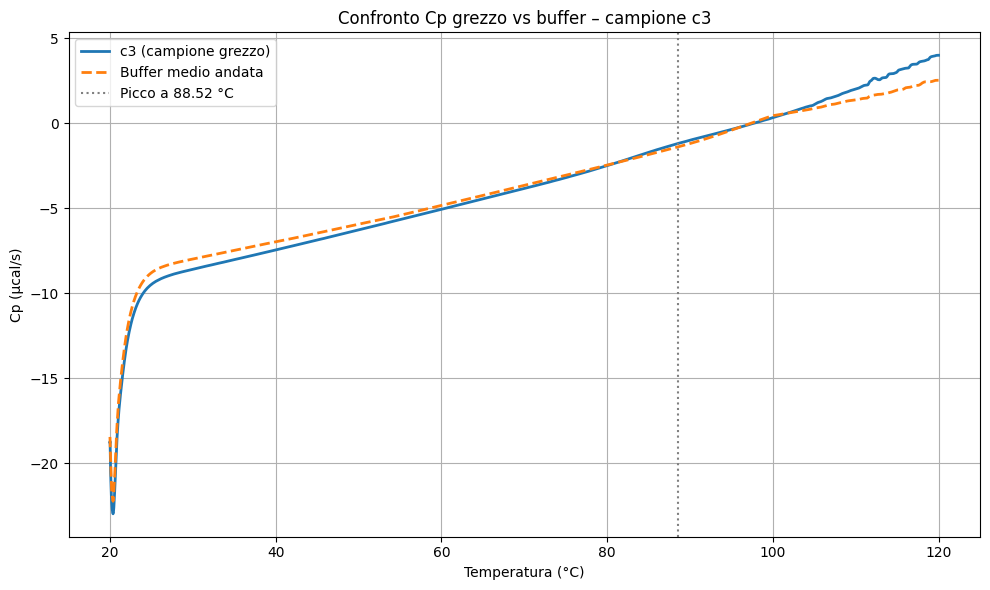

Temperatura del picco (80–100 °C): 88.52 °C
Cp grezzo del campione c3 a T = 88.52 °C: -1.1980 µcal/s
Cp del buffer interpolato a T = 88.52 °C: -1.4006 µcal/s


In [26]:
# Seleziona il campione
df_sample = cmyc_dataframes_renamed["c3"].copy()
df_sample = df_sample.sort_values(by="Temperatura")

# Estrai T e Cp del campione
T_sample = df_sample["Temperatura"].values
Cp_sample = df_sample["Cp"].values

# Buffer medio di andata
T_buf = buffer_media_df_andata["Temperatura"].values
Cp_buf = buffer_media_df_andata["Cp_medio_andata"].values

# Interpolazione del buffer sul dominio del campione
Cp_buffer_interp = np.interp(T_sample, T_buf, Cp_buf)

# Maschera tra 80 e 100 °C
mask = (T_sample >= 80) & (T_sample <= 100)
T_masked = T_sample[mask]
Cp_sample_masked = Cp_sample[mask]
Cp_buffer_masked = Cp_buffer_interp[mask]

# Trova il picco nel campione
idx_max = np.argmax(Cp_sample_masked - Cp_buffer_masked)
T_max = T_masked[idx_max]
Cp_max_sample = Cp_sample_masked[idx_max]
Cp_at_T_max_buffer = Cp_buffer_masked[idx_max]

# Plot comparativo
plt.figure(figsize=(10, 6))
plt.plot(T_sample, Cp_sample, label="c3 (campione grezzo)", lw=2)
plt.plot(T_sample, Cp_buffer_interp, '--', label="Buffer medio andata", lw=2)
plt.axvline(T_max, color='gray', linestyle=':', label=f"Picco a {T_max:.2f} °C")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp (µcal/s)")
plt.title("Confronto Cp grezzo vs buffer – campione c3")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Output testuale
print(f"Temperatura del picco (80–100 °C): {T_max:.2f} °C")
print(f"Cp grezzo del campione c3 a T = {T_max:.2f} °C: {Cp_max_sample:.4f} µcal/s")
print(f"Cp del buffer interpolato a T = {T_max:.2f} °C: {Cp_at_T_max_buffer:.4f} µcal/s")


 Skipping c1: anomalous data
⏭ Già presente: sample_minus_buffer\c2_corr.csv
⏭ Già presente: sample_minus_buffer\c3_corr.csv
⏭ Già presente: sample_minus_buffer\c4_corr.csv
⏭ Già presente: sample_minus_buffer\c5_corr.csv
⏭ Già presente: sample_minus_buffer\c6_corr.csv
⏭ Già presente: sample_minus_buffer\c7_corr.csv
⏭ Già presente: sample_minus_buffer\c8_corr.csv


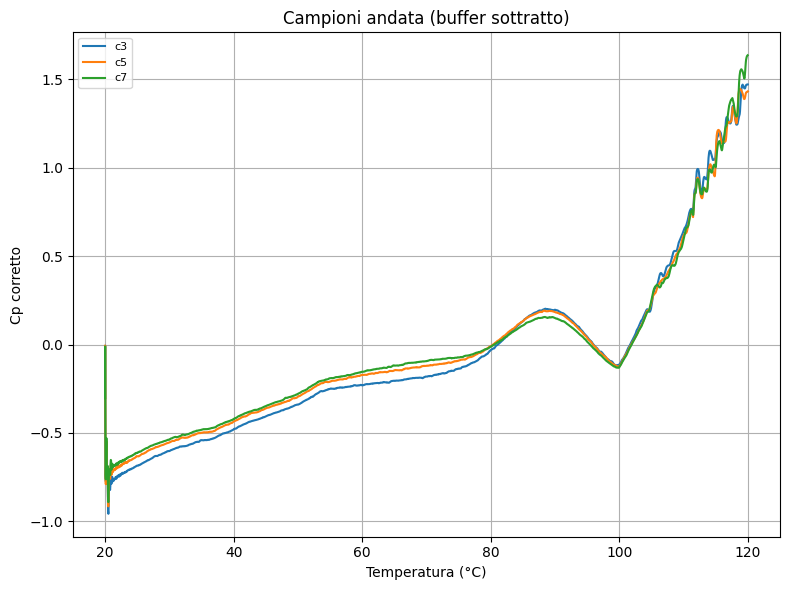

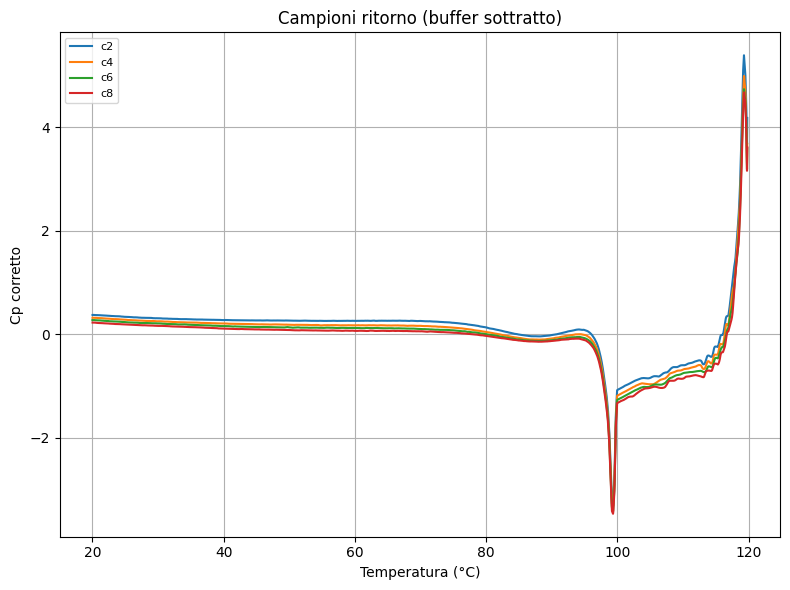

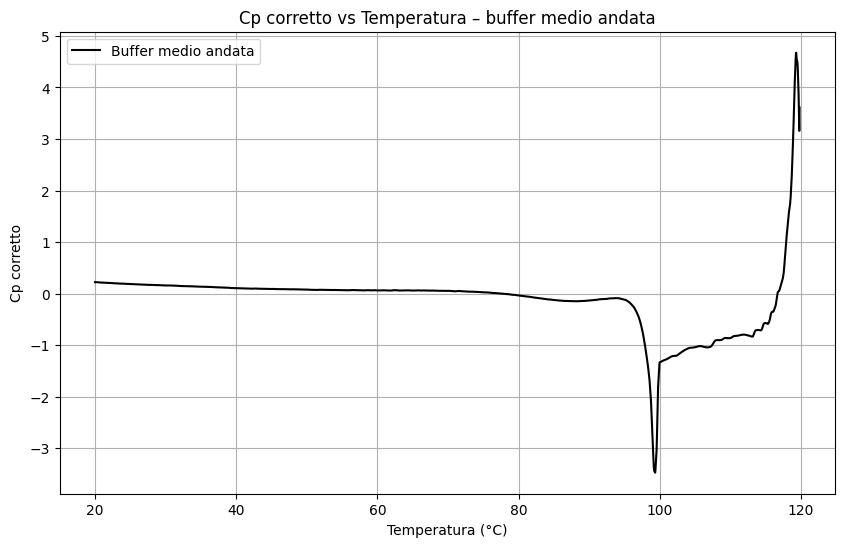

In [27]:
corr_data = {}

# Crea directory per salvataggio
output_dir = "sample_minus_buffer"
os.makedirs(output_dir, exist_ok=True)

# Buffer medi
T_andata = buffer_media_df_andata["Temperatura"].values
Cp_andata = buffer_media_df_andata["Cp_medio_andata"].values

T_ritorno = buffer_media_df_ritorno["Temperatura"].values
Cp_ritorno = buffer_media_df_ritorno["Cp_medio_ritorno"].values

# Figure separate
fig_andata, ax_andata = plt.subplots(figsize=(8, 6))
fig_ritorno, ax_ritorno = plt.subplots(figsize=(8, 6))

# Loop sui campioni
for name, df in cmyc_dataframes_renamed.items():

    # Salta c1
    if name == "c1":
        print(f" Skipping {name}: anomalous data")
        continue
    
    i = int(name[1:])
    is_andata = i % 2 == 1

    df_sorted = df.sort_values(by="Temperatura").reset_index(drop=True)
    T_sample = df_sorted["Temperatura"].values
    Cp_sample = df_sorted["Cp"].values

    T_buf = T_andata if is_andata else T_ritorno
    Cp_buf = Cp_andata if is_andata else Cp_ritorno
    Cp_buffer_interp = np.interp(T_sample, T_buf, Cp_buf)

    Cp_corr = Cp_sample - Cp_buffer_interp

    # Salvataggio
    df_corr = pd.DataFrame({"Temperatura": T_sample, "Cp_corretto": Cp_corr})
    corr_data[name] = df_corr

    file_path = os.path.join(output_dir, f"{name}_corr.csv")
    if not os.path.exists(file_path):
        df_corr.to_csv(file_path, sep='\t', index=False)
        print(f" Salvato: {file_path}")
    else:
        print(f"⏭ Già presente: {file_path}")

    # Plot nella figura giusta
    if is_andata:
        ax_andata.plot(T_sample, Cp_corr, label=name)
    else:
        ax_ritorno.plot(T_sample, Cp_corr, label=name)

# Titoli e assi
ax_andata.set_title("Campioni andata (buffer sottratto)")
ax_andata.set_xlabel("Temperatura (°C)")
ax_andata.set_ylabel("Cp corretto")
ax_andata.grid(True)
ax_andata.legend(fontsize=8)

ax_ritorno.set_title("Campioni ritorno (buffer sottratto)")
ax_ritorno.set_xlabel("Temperatura (°C)")
ax_ritorno.set_ylabel("Cp corretto")
ax_ritorno.grid(True)
ax_ritorno.legend(fontsize=8)

# Mostra i plot
fig_andata.tight_layout()
fig_ritorno.tight_layout()
plt.show()

# Plot separato per buffer medio andata
plt.figure(figsize=(10, 6))
plt.plot(df_corr["Temperatura"], df_corr["Cp_corretto"], label="Buffer medio andata", color="black")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp corretto")
plt.title("Cp corretto vs Temperatura – buffer medio andata")
plt.grid(True)
plt.legend()
plt.show()


## Normalizzazione dei dati:

### µcal/s → cal/mol·°C

Per analizzare i dati calorimetrici secondo il modello termodinamico di **Spink**, è essenziale che il segnale di capacità termica sia espresso in **unità compatibili con il modello**, ovvero in **calorie per mole e per grado Celsius** (cal/mol·°C).  
Il segnale grezzo fornito dallo strumento è espresso in **µcal/s** e va trasformato secondo i seguenti passaggi:

### Conversione step-by-step:

1. **Divisione per il numero di moli nel campione**  
   Si ricava dal volume e dalla concentrazione della soluzione:
   $$
   \text{moli} = \left( \frac{\text{volume (µL)}}{10^6} \right) \cdot \left( \frac{\text{concentrazione (µM)}}{10^6} \right)
   $$
   $$
   \text{Cp}_{\mu\text{cal}/(\text{mol} \cdot s)} = \frac{\text{Cp}_{\mu\text{cal}/s}}{\text{moli}}
   $$


2. **Divisione per il tasso di scansione**  
   Per ottenere l’integrale nel dominio della temperatura anziché del tempo:  
   $$
   \text{Cp}_{\mu\text{cal}/ \text{mol} \cdot °C } = \frac{\text{Cp}_{\mu\text{cal}/(\text{mol} \cdot s)}}{\text{Scan rate (°C/s)}}
   $$


3. **Divisione per 10^6**  
   Passaggio da microcalorie a calorie.
   

###  Parametri usati nella normalizzazione:
- **Scan rate:** 0.5 °C/s  
- **Volume:** 300 µL  
- **Concentrazione:** 40 µM = 40 × 10⁻⁶ mol/L  
- **Unità finale:** cal / (mol·°C)

---

Questa normalizzazione è **obbligatoria per garantire la corretta interpretazione** dei dati termici nei modelli termodinamici di unfolding a più stati (es. modello sequenziale di Spink), dove l’entalpia è integrata direttamente dal segnale Cp(T) espresso per mole.

>  **Tutti i dati riportati nelle successive analisi sono stati trattati con questa precisa procedura di normalizzazione.**


In [28]:
def normalizza_dizionari_cp(dizionario_dati, scan_rate_m=0.5, volume_ul=300, concentrazione_uM=45):
    """
    Normalizza i Cp da µcal/s a Cal / (mol·°C) per ogni DataFrame in un dizionario.

    Parametri:
    - dizionario_dati: dict con DataFrame contenenti colonne 'Temperatura' e 'Cp'
    - scan_rate: velocità di scansione in °C/s (default 0.5)
    - volume_ul: volume del campione in uL (default 300)
    - concentrazione_uM: concentrazione del campione in µM (default 40)

    Output:
    - nuovo dizionario con colonna 'Cp_normalizzato' in Cal / (mol·°C)
    """

    # Conversioni
    volume_L = volume_ul / 1e6  # uL → L
    concentrazione_M = concentrazione_uM / 1e6  # µM → mol/L
    moli_totali = volume_L * concentrazione_M  # moli nel campione

    dizionario_normalizzato = {}

    for name, df in dizionario_dati.items():
        df = df.copy()

        if "Cp_corretto" not in df.columns:
            print(f"  Colonna 'Cp' mancante in {name}, saltato.")
            continue

        # Step 1: Cp è in µcal/s → dividi per moli → µcal/(mol·s)
        cp_mucal_per_mol_per_s = df["Cp_corretto"].values / moli_totali

        scan_rate = scan_rate_m / 60  # Converti da °C/min a °C/s
        # Step 2: dividi per scan_rate (°C/s) → µcal/(mol·°C)
        cp_mucal_per_mol_per_C = cp_mucal_per_mol_per_s / scan_rate

        # Step 3: converti da µcal → Cal → Cal/(mol·°C)
        cp_Cal_per_mol_per_C = cp_mucal_per_mol_per_C / 1e6

        df["Cp_normalizzato"] = cp_Cal_per_mol_per_C
        dizionario_normalizzato[name] = df

    return dizionario_normalizzato

df_corr = normalizza_dizionari_cp(corr_data)

for name, df in df_corr.items():
    print(f"{name} → prime 3 righe Cp normalizzato:")
    print(df[["Temperatura", "Cp_normalizzato"]].head(3), "\n")



c2 → prime 3 righe Cp normalizzato:
   Temperatura  Cp_normalizzato
0       20.018      3287.450242
1       20.060      3291.994634
2       20.101      3288.388498 

c3 → prime 3 righe Cp normalizzato:
   Temperatura  Cp_normalizzato
0       20.003     -2682.409350
1       20.018       -58.900546
2       20.050     -4719.859541 

c4 → prime 3 righe Cp normalizzato:
   Temperatura  Cp_normalizzato
0       20.016      2800.038075
1       20.057      2805.320828
2       20.099      2809.865220 

c5 → prime 3 righe Cp normalizzato:
   Temperatura  Cp_normalizzato
0       20.003     -2691.298239
1       20.018       -50.011657
2       20.043     -3357.496983 

c6 → prime 3 righe Cp normalizzato:
   Temperatura  Cp_normalizzato
0       19.998      2402.962963
1       20.040      2400.095188
2       20.083      2403.901219 

c7 → prime 3 righe Cp normalizzato:
   Temperatura  Cp_normalizzato
0       20.003     -2691.298239
1       20.018       -94.456101
2       20.043     -3401.941427 

c8 →

In [29]:
# Check coerenza nomi e colonne
for name, df in df_corr.items():
    assert isinstance(name, str) and name.startswith("c"), f"Nome non valido: {name}"
    assert "Cp_normalizzato" in df.columns, f"{name} manca 'Cp_normalizzato'"


## Ricerca baseline ottimale:

Dopo la correzione per il contributo del buffer, è necessario imporre una seconda baseline ai dati, al fine di stimare correttamente le regioni pre- e post-transizione del segnale DSC, cioè quelle al di fuori del picco calorimetrico. La scelta della baseline rappresenta uno dei passaggi più critici dell'analisi, in quanto influisce in modo diretto sulla stima dei parametri termodinamici (come ΔH e ΔCp).

Diverse procedure di costruzione della baseline sono comunemente implementate nei software DSC: tra queste vi sono funzioni lineari, spline, polinomiali cubiche e funzioni a gradino o sigmoidi. In questa analisi è stato effettuato un confronto tra più modelli di baseline, partendo da forme lineari fino a funzioni più flessibili come quella cubica, la funzione a gradino e la sigmoide.

Dal punto di vista fisico, l’operazione di sottrazione della baseline equivale a rimuovere il contributo al calore specifico del campione nello stato completamente nativo (foldato) e completamente denaturato (unfoldato), oltre al contributo residuo del buffer. L’obiettivo è isolare la variazione di capacità termica attribuibile alla transizione conformazionale stessa.

## Procedura automatica per la sottrazione della baseline (metodo della derivata)

Questa procedura automatizza la sottrazione della baseline dai dati DSC ($C_p$ vs Temperatura), basandosi sull'identificazione dell'inizio del picco mediante la derivata prima.

### Passaggi principali:

1. **Taglio del dominio di temperatura**

Vengono eliminati tutti i dati sopra una soglia massima (es. 100.5 °C), per evitare rumore o ritorni post-picco.

2. **Calcolo della derivata prima**

Si calcola numericamente:

$$
\frac{dC_p}{dT}
$$

per evidenziare le regioni dove il segnale cambia rapidamente.

3. **Stima del rumore**

Si assume che nella regione $[40^\circ C, 50^\circ C]$ non ci siano transizioni. Si calcola:

$$
\sigma_{\text{noise}} = \text{std}\left(\frac{dC_p}{dT} \bigg|_{[40^\circ C, 50^\circ C]}\right)
$$

4. **Definizione di una soglia dinamica**

Si stabilisce una soglia come multiplo della deviazione standard:

$$
\text{soglia} = k \cdot \sigma_{\text{noise}}
$$

dove $k$ è un parametro empirico (es. 3).

5. **Ricerca del salto nel range di transizione**

All'interno del range $[70^\circ C, 85^\circ C]$, si cerca la prima sequenza di almeno $n$ punti consecutivi tali che:

$$
\frac{dC_p}{dT} > \text{soglia}
$$

Questa condizione identifica l’inizio della transizione termica.

6. **Zona di fit pre-picco**

Si definisce la zona su cui effettuare il fit:

$$
T_{\text{fit}} \in [T_{\text{start}}, T_{\text{picco}}] = [T[i_{\text{picco}} - N], T[i_{\text{picco}}]]
$$

dove $N$ è il numero di punti da considerare per il fit.


### Considerazioni finali

- Il metodo evita soggettività nell'identificazione del tratto pre-picco.
- È ideale per pipeline riproducibili in analisi termodinamiche.
- I parametri $(k, N, \text{window}, \text{range})$ possono essere adattati per diversi dataset.


### Baseline lineare: 
Si conclude la procedura di prima come segue: 

7. **Fit lineare della baseline**

La baseline è stimata con una regressione lineare:

$$
C_p^{\text{baseline}}(T) = mT + q
$$

8. **Sottrazione della baseline**

Si ottiene il segnale corretto come:

$$
C_p^{\text{finale}} = C_p^{\text{corretto}} - C_p^{\text{baseline}}(T)
$$



In [30]:
from scipy.stats import linregress
import ipywidgets as widgets
from IPython.display import display

# Dizionario finale per salvare i risultati del fit
baseline_data_lineare_vincolata = {}

# Parametri principali
n_punti_pre = 200        # Numero di punti prima del picco per il fit
n_punti_post = 10        # Numero di punti finali da usare nel fit
T_max_cutoff = 100.1     # Temperatura massima da considerare
soglia_std_multiplier = 2
window = 6               # Numero di punti consecutivi sopra soglia richiesti per identificare il picco

# Loop sui campioni normalizzati
for name, df in df_corr.items():

    # Salta i campioni pari e il c1 (escludi se hanno forma anomala)
    if name == "c1" or int(name[1:]) % 2 == 0:
        continue

    # Estrai i dati di temperatura e Cp
    T = df["Temperatura"].values
    Cp = df["Cp_normalizzato"].values

    # Verifica coerenza dimensioni
    if len(T) != len(Cp):
        continue

    # Ordina i dati per temperatura crescente
    sort_idx = np.argsort(T)
    T, Cp = T[sort_idx], Cp[sort_idx]

    # Escludi punti oltre il massimo desiderato (es. 100.2 °C)
    mask = T <= T_max_cutoff
    T, Cp = T[mask], Cp[mask]

    # Calcola la derivata numerica dCp/dT per individuare zone con variazioni forti
    dCp_dT = np.gradient(Cp, T)

    # Calcola la deviazione standard della derivata in una zona "piatta" (es. 40–50 °C)
    mask_fondo = (T >= 40) & (T <= 50)
    sigma_noise = np.std(dCp_dT[mask_fondo])

    # Definisce la soglia come un multiplo della deviazione standard
    soglia = soglia_std_multiplier * sigma_noise

    # Cerca un salto nella derivata tra 70–85 °C, cioè la zona del picco termico
    mask_picco = (T >= 70) & (T <= 85)
    indices_picco = np.where(mask_picco)[0]

    idx_picco = None
    for i in indices_picco:
        if i + window >= len(dCp_dT):
            break
        if np.all(dCp_dT[i:i+window] > soglia):
            idx_picco = i
            break

    # Se non trova un picco affidabile, o se è troppo vicino all’inizio, salta
    if idx_picco is None or idx_picco < n_punti_pre:
        print(f"{name}: nessun salto consistente trovato o troppo vicino all'inizio.")
        continue

    # --- Sezione di fit: parte iniziale (pre-picco) ---
    idx_fit_pre_start = idx_picco - n_punti_pre
    idx_fit_pre_stop = idx_picco

    T_fit_pre = T[idx_fit_pre_start:idx_fit_pre_stop]
    Cp_fit_pre = Cp[idx_fit_pre_start:idx_fit_pre_stop]

    # --- Sezione di fit: parte finale della curva ---
    idx_fit_post_start = -n_punti_post
    T_fit_post = T[idx_fit_post_start:]
    Cp_fit_post = Cp[idx_fit_post_start:]

    # --- Costruzione del dataset totale per il fit lineare ---
    T_fit = np.concatenate([T_fit_pre, T_fit_post])
    Cp_fit = np.concatenate([Cp_fit_pre, Cp_fit_post])

    # Se troppo pochi punti totali, salta
    if len(T_fit) < 3:
        print(f"{name}: troppi pochi punti per il fit totale.")
        continue

    # --- Fit lineare su inizio + fine ---
    slope, intercept, *_ = linregress(T_fit, Cp_fit)

    # Costruisci la baseline su tutta la curva usando il fit
    baseline = slope * T + intercept

    # Cp corretto = Cp osservato - baseline
    Cp_finale = Cp - baseline

    # Salva in DataFrame
    df_out = pd.DataFrame({
        "Temperatura": T,
        "Cp_corretto": Cp,
        "Cp_baseline": baseline,
        "Cp_finale_lineare": Cp_finale
    })

    # Salva tutto in dizionario
    baseline_data_lineare_vincolata[name] = {
        "df": df_out,
        "T_start": T[idx_fit_pre_start]
    }

    print(f"{name}: baseline vincolata da T_start = {T[idx_fit_pre_start]:.2f} °C a T_end = {T[-1]:.2f} °C")

# ---------- Interfaccia interattiva ----------
def plot_sample(name):
    df = baseline_data_lineare_vincolata[name]["df"]
    plt.figure(figsize=(8, 5))
    plt.plot(df["Temperatura"], df["Cp_corretto"], label="Cp netto", alpha=0.6)
    plt.plot(df["Temperatura"], df["Cp_baseline"], '--', label="Baseline stimata")
    plt.plot(df["Temperatura"], df["Cp_finale_lineare"], label="Cp pulito")
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("Cp")
    plt.title(f"{name} – baseline lineare vincolata")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Dropdown per esplorare i campioni
dropdown = widgets.Dropdown(
    options=sorted(baseline_data_lineare_vincolata.keys()),
    description='Campione:',
    layout=widgets.Layout(width='40%')
)

widgets.interact(plot_sample, name=dropdown)


c3: baseline vincolata da T_start = 65.92 °C a T_end = 100.06 °C
c5: baseline vincolata da T_start = 70.47 °C a T_end = 100.08 °C
c7: baseline vincolata da T_start = 70.04 °C a T_end = 100.09 °C


interactive(children=(Dropdown(description='Campione:', layout=Layout(width='40%'), options=('c3', 'c5', 'c7')…

<function __main__.plot_sample(name)>

### Baseline cubica:
Si conclude la procedura automatica come segue:

7. **Fit cubico della baseline**

La baseline viene stimata mediante un polinomio di terzo grado:

$$
C_p^{\text{baseline}}(T) = aT^3 + bT^2 + cT + d
$$

A differenza degli altri casi, per garantire stabilità numerica e evitare overfitting locale, il fit viene eseguito su **300 punti consecutivi prima del picco**.  
Questo corrisponde a un intervallo di circa **12–15 °C**, necessario per vincolare correttamente i 4 coefficienti del polinomio cubico e prevenire divergenze numeriche.

8. **Sottrazione della baseline**

Il segnale corretto si ottiene come:

$$
C_p^{\text{finale}} = C_p^{\text{corretto}} - C_p^{\text{baseline}}(T)
$$

In [31]:

baseline_data_cubica_vincolata = {}

# Parametri principali
n_punti_pre = 300         # punti da usare prima del picco
n_punti_post = 10         # punti finali da usare come vincolo
T_max_cutoff = 100.1
soglia_std_multiplier = 2
window = 6                # quanti punti consecutivi sopra soglia per identificare il picco

for name, df in df_corr.items():
    # Salta i campioni pari o c1
    if name == "c1" or int(name[1:]) % 2 == 0:
        continue

    # Estrai temperatura e Cp
    T = df["Temperatura"].values
    Cp = df["Cp_normalizzato"].values

    if len(T) != len(Cp):
        continue

    # Ordina per temperatura crescente
    sort_idx = np.argsort(T)
    T, Cp = T[sort_idx], Cp[sort_idx]

    # Limita l’intervallo massimo di temperatura
    mask = T <= T_max_cutoff
    T, Cp = T[mask], Cp[mask]

    # Calcola derivata numerica per identificare il picco
    dCp_dT = np.gradient(Cp, T)

    # Calcola il rumore della derivata tra 40–50 °C
    mask_fondo = (T >= 40) & (T <= 50)
    sigma_noise = np.std(dCp_dT[mask_fondo])
    soglia = soglia_std_multiplier * sigma_noise

    # Cerca il primo salto significativo tra 70–85 °C
    mask_picco = (T >= 70) & (T <= 85)
    indices_picco = np.where(mask_picco)[0]

    idx_picco = None
    for i in indices_picco:
        if i + window >= len(dCp_dT):
            break
        if np.all(dCp_dT[i:i+window] > soglia):
            idx_picco = i
            break

    if idx_picco is None or idx_picco < n_punti_pre:
        print(f"{name}: nessun salto consistente trovato o troppo vicino all'inizio.")
        continue

    # --- Fit con vincolo iniziale + finale ---
    idx_fit_pre_start = idx_picco - n_punti_pre
    idx_fit_pre_stop = idx_picco

    T_fit_pre = T[idx_fit_pre_start:idx_fit_pre_stop]
    Cp_fit_pre = Cp[idx_fit_pre_start:idx_fit_pre_stop]

    # Aggiungi gli ultimi punti come vincolo (es. ultimi 10)
    T_fit_post = T[-n_punti_post:]
    Cp_fit_post = Cp[-n_punti_post:]

    # Concatenazione dei dati di fit
    T_fit = np.concatenate([T_fit_pre, T_fit_post])
    Cp_fit = np.concatenate([Cp_fit_pre, Cp_fit_post])

    # Serve almeno 4 punti per un fit cubico
    if len(T_fit) < 4:
        print(f"{name}: troppo pochi punti per il fit cubico, saltato.")
        continue

    # Fit cubico (grado 3) → coeffs[0] + coeffs[1]*T + coeffs[2]*T² + coeffs[3]*T³
    coeffs = np.polyfit(T_fit, Cp_fit, deg=3)

    # Valuta la baseline su tutti i T
    baseline = np.polyval(coeffs, T)

    # Cp corretto = Cp osservato - baseline stimata
    Cp_finale = Cp - baseline

    # Salva in DataFrame
    df_out = pd.DataFrame({
        "Temperatura": T,
        "Cp_corretto": Cp,
        "Cp_baseline": baseline,
        "Cp_finale_cubica": Cp_finale
    })

    baseline_data_cubica_vincolata[name] = {
        "df": df_out,
        "T_start": T[idx_fit_pre_start]
    }

    print(f"{name}: fit cubico vincolato da T = {T[idx_fit_pre_start]:.2f} °C a T = {T[-1]:.2f} °C")

# -------- Interfaccia interattiva --------
def plot_sample(name):
    df = baseline_data_cubica_vincolata[name]["df"]
    plt.figure(figsize=(8, 5))
    plt.plot(df["Temperatura"], df["Cp_corretto"], label="Cp netto", alpha=0.6)
    plt.plot(df["Temperatura"], df["Cp_baseline"], '--', label="Baseline cubica")
    plt.plot(df["Temperatura"], df["Cp_finale_cubica"], label="Cp pulito")
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("Cp")
    plt.title(f"{name} – Fit baseline cubica vincolata")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

dropdown = widgets.Dropdown(
    options=sorted(baseline_data_cubica_vincolata.keys()),
    description='Campione:',
    layout=widgets.Layout(width='40%')
)

widgets.interact(plot_sample, name=dropdown)

c3: fit cubico vincolato da T = 61.75 °C a T = 100.06 °C
c5: fit cubico vincolato da T = 66.29 °C a T = 100.08 °C
c7: fit cubico vincolato da T = 65.87 °C a T = 100.09 °C


interactive(children=(Dropdown(description='Campione:', layout=Layout(width='40%'), options=('c3', 'c5', 'c7')…

<function __main__.plot_sample(name)>

### Baseline a gradino:

Si propone una variante al metodo precedente in cui, invece della regressione lineare, la baseline viene modellata come un **gradino** composto da due tratti costanti.

#### 7. Definizione del gradino

La baseline viene costruita come:

- Un valore costante prima del picco, pari alla media di $C_p$ su $N$ punti precedenti l’inizio della transizione:

$$
C_p^{\text{bassa}} = \frac{1}{N} \sum_{i=i_{\text{picco}} - N}^{i_{\text{picco}} - 1} C_p[i]
$$

- Un valore costante dopo il picco, pari alla media degli ultimi $N$ punti del tratto considerato (fino a $100.5^\circ$ C):

$$
C_p^{\text{alta}} = \frac{1}{N} \sum_{i=-N}^{-1} C_p[i]
$$

- Il **salto** del gradino avviene in corrispondenza del **massimo del segnale**:

$$
i_{\text{max}} = \arg\max(C_p)
$$

Quindi la baseline completa è:

$$
C_p^{\text{baseline}}(T) =
\begin{cases}
C_p^{\text{bassa}} & \text{se } i < i_{\text{max}} \\
C_p^{\text{alta}} & \text{se } i \ge i_{\text{max}}
\end{cases}
$$

#### 8. Sottrazione della baseline

Il segnale corretto è ottenuto come:

$$
C_p^{\text{finale}} = C_p^{\text{corretto}} - C_p^{\text{baseline}}
$$


In [32]:
baseline_data_gradino = {}
n_punti_pre = 200
n_punti_post = 10
T_max_cutoff = 100.2
soglia_std_multiplier = 2  # moltiplicatore per la soglia sulla derivata
window = 6  # numero di punti consecutivi sopra soglia richiesti

for name, df in df_corr.items():
    if name == "c1" or int(name[1:]) % 2 == 0:
        continue

    T = df["Temperatura"].values
    Cp = df["Cp_normalizzato"].values
    if len(T) != len(Cp):
        continue

    sort_idx = np.argsort(T)
    T, Cp = T[sort_idx], Cp[sort_idx]

    mask = T <= T_max_cutoff
    T, Cp = T[mask], Cp[mask]

    dCp_dT = np.gradient(Cp, T)

    mask_fondo = (T >= 40) & (T <= 50)
    sigma_noise = np.std(dCp_dT[mask_fondo])
    soglia = soglia_std_multiplier * sigma_noise

    mask_picco = (T >= 70) & (T <= 85)
    indices_picco = np.where(mask_picco)[0]

    idx_picco = None
    for i in indices_picco:
        if i + window >= len(dCp_dT):
            break
        if np.all(dCp_dT[i:i+window] > soglia):
            idx_picco = i
            break

    if idx_picco is None or idx_picco < n_punti_pre:
        print(f"{name}: nessun salto consistente trovato o troppo vicino all'inizio.")
        continue

    # --- definizione del gradino ---
    idx_fit_stop = idx_picco
    idx_fit_start = idx_fit_stop - n_punti_pre

    # Prima baseline costante (come prima della regressione)
    baseline_low = np.mean(Cp[idx_fit_start:idx_fit_stop])

    # Dopo il picco → uso ultimi 10 punti validi
    idx_fit_post = -n_punti_post
    baseline_high = np.mean(Cp[idx_fit_post:])

    # Posizione del salto esattamente al massimo di Cp
    idx_max = np.argmax(Cp)

    # Costruzione gradino
    baseline = np.full_like(Cp, baseline_high)
    baseline[:idx_max] = baseline_low
    Cp_finale = Cp - baseline

    df_out = pd.DataFrame({
        "Temperatura": T,
        "Cp_corretto": Cp,
        "Cp_baseline": baseline,
        "Cp_finale_gradino": Cp_finale
    })
    baseline_data_gradino[name] =  {
        "df": df_out,
        "T_start": T[idx_fit_start]
    }

    print(f"{name}: gradino centrato a T = {T[idx_max]:.2f} °C "
          f"(baseline_low = {baseline_low:.3f}, baseline_high = {baseline_high:.3f})")

# ---------- interfaccia ----------
def plot_sample(name):
    df = baseline_data_gradino[name]["df"]
    plt.figure(figsize=(8, 5))
    plt.plot(df["Temperatura"], df["Cp_corretto"], label="Cp netto", alpha=0.6)
    plt.plot(df["Temperatura"], df["Cp_baseline"], '--', label="Baseline a gradino")
    plt.plot(df["Temperatura"], df["Cp_finale_gradino"], label="Cp pulito")
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("Cp")
    plt.title(f"{name} – baseline a gradino corretta")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

dropdown = widgets.Dropdown(
    options=sorted(baseline_data_gradino.keys()),
    description='Campione:',
    layout=widgets.Layout(width='40%')
)
widgets.interact(plot_sample, name=dropdown)


c3: gradino centrato a T = 88.52 °C (baseline_low = -1584.702, baseline_high = -996.132)
c5: gradino centrato a T = 88.33 °C (baseline_low = -790.719, baseline_high = -1084.412)
c7: gradino centrato a T = 88.43 °C (baseline_low = -642.037, baseline_high = -1131.795)


interactive(children=(Dropdown(description='Campione:', layout=Layout(width='40%'), options=('c3', 'c5', 'c7')…

<function __main__.plot_sample(name)>

### Baseline sigmoide:

Si propone una terza modalità di stima della baseline, in cui essa è modellata da una **sigmoide** (funzione logistica) centrata sul massimo del picco.

#### 7. Definizione della sigmoide

Si utilizza una funzione logistica del tipo:

$$
f(T) = A + \frac{B - A}{1 + e^{-k(T - T_0)}}
$$

dove:

- $A$ è la baseline bassa (prima del picco),
- $B$ è la baseline alta (dopo il picco),
- $k$ controlla la **pendenza** del salto (tipicamente un valore empirico),
- $T_0$ è la **temperatura corrispondente al massimo di $C_p$**:

$$
T_0 = T[i_{\text{max}}] \quad \text{dove} \quad i_{\text{max}} = \arg\max(C_p)
$$

I valori $A$ e $B$ sono stimati come:

- Media dei punti **prima** dell’inizio del picco:

$$
A = \frac{1}{N} \sum_{i = i_{\text{picco}} - N}^{i_{\text{picco}} - 1} C_p[i]
$$

- Media degli ultimi $N$ punti validi:

$$
B = \frac{1}{N} \sum_{i = -N}^{-1} C_p[i]
$$

Il parametro $k$ può essere fissato (es. $k = 0.3$) in base alla larghezza del salto desiderato.

#### 8. Sottrazione della baseline

La baseline stimata è quindi:

$$
C_p^{\text{baseline}}(T) = f(T)
$$

Il segnale corretto si ottiene come:

$$
C_p^{\text{finale}} = C_p^{\text{corretto}} - C_p^{\text{baseline}}(T)
$$


In [33]:
from scipy.optimize import curve_fit

def sigmoid_manual(T, A, B, k, T0):
    return A + (B - A) / (1 + np.exp(-k * (T - T0)))

baseline_data_sigmoide = {}
n_punti_fit = 120
n_punti_post = 10
T_max_cutoff = 100.2
soglia_std_multiplier = 2
window = 6
pendenza_sigmoide = 0.3  # controllo della "ripidità"

for name, df in df_corr.items():
    if name == "c1" or int(name[1:]) % 2 == 0:
        continue

    T = df["Temperatura"].values
    Cp = df["Cp_normalizzato"].values
    if len(T) != len(Cp):
        continue

    sort_idx = np.argsort(T)
    T, Cp = T[sort_idx], Cp[sort_idx]

    mask = T <= T_max_cutoff
    T, Cp = T[mask], Cp[mask]

    dCp_dT = np.gradient(Cp, T)

    mask_fondo = (T >= 40) & (T <= 50)
    sigma_noise = np.std(dCp_dT[mask_fondo])
    soglia = soglia_std_multiplier * sigma_noise

    mask_picco = (T >= 70) & (T <= 85)
    indices_picco = np.where(mask_picco)[0]

    idx_picco = None
    for i in indices_picco:
        if i + window >= len(dCp_dT):
            break
        if np.all(dCp_dT[i:i+window] > soglia):
            idx_picco = i
            break

    if idx_picco is None or idx_picco < n_punti_fit:
        print(f"{name}: nessun salto consistente trovato o troppo vicino all'inizio.")
        continue

    idx_fit_start = idx_picco - n_punti_fit
    if idx_fit_start < 0:
        print(f"{name}: troppo pochi punti per il fit, saltato.")
        continue

    # Media prima del picco (costante bassa)
    baseline_low = np.mean(Cp[idx_fit_start:idx_picco])

    # Media dopo il picco (ultimi 2 punti)
    baseline_high = np.mean(Cp[-n_punti_post:])

    # Centro della sigmoide → massimo del Cp
    idx_max = np.argmax(Cp)
    T0 = T[idx_max]

    # Costruzione della baseline sigmoide smussata
    baseline = sigmoid_manual(T, baseline_low, baseline_high, pendenza_sigmoide, T0)
    Cp_finale_sigmoide = Cp - baseline

    df_out = pd.DataFrame({
        "Temperatura": T,
        "Cp_corretto": Cp,
        "Cp_baseline": baseline,
        "Cp_finale_sigmoide": Cp_finale_sigmoide
    })
    baseline_data_sigmoide[name] =  {
        "df": df_out,
        "T_start": T[idx_fit_start]
    }

    print(f"{name}: sigmoide centrata a T = {T0:.2f} °C "
          f"(low = {baseline_low:.3f}, high = {baseline_high:.3f})")

# Interfaccia interattiva
def plot_sample_sigmoide(name):
    df = baseline_data_sigmoide[name]["df"]
    plt.figure(figsize=(8, 5))
    plt.plot(df["Temperatura"], df["Cp_corretto"], label="Cp netto", alpha=0.6)
    plt.plot(df["Temperatura"], df["Cp_baseline"], '--', label="Baseline sigmoide")
    plt.plot(df["Temperatura"], df["Cp_finale_sigmoide"], label="Cp pulito")
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("Cp")
    plt.title(f"{name} – baseline sigmoide smussata")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

dropdown = widgets.Dropdown(
    options=sorted(baseline_data_sigmoide.keys()),
    description='Campione:',
    layout=widgets.Layout(width='40%')
)
widgets.interact(plot_sample_sigmoide, name=dropdown)

c3: sigmoide centrata a T = 88.52 °C (low = -1497.799, high = -996.132)
c5: sigmoide centrata a T = 88.33 °C (low = -665.405, high = -1084.412)
c7: sigmoide centrata a T = 88.43 °C (low = -569.102, high = -1131.795)


interactive(children=(Dropdown(description='Campione:', layout=Layout(width='40%'), options=('c3', 'c5', 'c7')…

<function __main__.plot_sample_sigmoide(name)>

Grazie a questa pipeline è possibile estrarre il picco con parametri preimpostati, per rendere il codice più generalizzabile possibile è stato considerato utile inserire ulteriori celle che permettono all'utente di scegliere i parametri per estrarre il picco in qualsiasi dato DSC in base alle caratteristiche e alla quantità di informazione che più si addice al caso in esame.

### Identificazione dell'inizio del picco tramite la derivata prima

Per individuare in modo oggettivo l'inizio della transizione termica nei dati DSC ($C_p$ vs Temperatura), è utile analizzare la **derivata numerica** del segnale:

$$
\frac{dC_p}{dT}
$$

Questa rappresenta la variazione istantanea di $C_p$ rispetto alla temperatura, ed è particolarmente sensibile ai cambiamenti rapidi nel profilo, come quelli presenti all’inizio del picco.

#### Calcolo della soglia

Per identificare inizio picco, si introduce una **soglia dinamica** basata sulla deviazione standard del rumore nella regione stabile $[40^\circ C, 50^\circ C]$:

$$
\sigma = \text{std} \left( \left. \frac{dC_p}{dT} \right|_{[40^\circ C, 50^\circ C]} \right)
$$

La soglia viene definita come:

$$
\text{soglia} = k \cdot \sigma
$$

dove $k$ è un moltiplicatore regolabile (tipicamente $1.2 \leq k \leq 2.5$).  
La soglia appare nel grafico come **linea orizzontale rossa**.

#### Parametro window

Per evitare falsi positivi dovuti al rumore, non è sufficiente che la derivata superi la soglia **una sola volta**. Si richiede invece che lo faccia per almeno $n$ punti consecutivi (parametro window):

$$
\frac{dC_p}{dT}(T_i), \ldots, \frac{dC_p}{dT}(T_{i+n}) > \text{soglia}
$$

Se questa condizione è soddisfatta in un intervallo di interesse (tipicamente $[70^\circ C, 85^\circ C]$), si fissa:

$$
T_{\text{start}} = T_i
$$

come **inizio del picco termico**.

---

### Utilità del grafico interattivo

Il grafico della derivata interattiva permette di:

- **Visualizzare il comportamento della derivata** su tutta la curva.
- **Verificare l'effetto del moltiplicatore $\sigma$** sulla soglia.
- **Valutare la robustezza della soglia** al variare di window.
- **Validare visivamente l'identificazione dell’inizio del picco**, evidenziato dalla linea verde.

Questo strumento è fondamentale per scegliere parametri ottimali e rendere l'estrazione dei picchi più affidabile e riproducibile.

---


In [34]:
from IPython.display import clear_output

def plot_cp_con_derivata(campione='c3', soglia_mult=2, window=6):
    df = df_corr[campione]
    T_all = df["Temperatura"].values
    Cp_all = df["Cp_normalizzato"].values

    # Filtra 30–100 °C
    mask = (T_all >= 30) & (T_all <= 100)
    T = T_all[mask]
    Cp = Cp_all[mask]

    # Ordina
    sort_idx = np.argsort(T)
    T = T[sort_idx]
    Cp = Cp[sort_idx]

    # Derivata numerica
    dCp_dT = np.gradient(Cp, T)

    # Soglia sul fondo (40–50 °C)
    mask_fondo = (T >= 40) & (T <= 50)
    sigma = np.std(dCp_dT[mask_fondo])
    soglia = soglia_mult * sigma

    # Cerca inizio picco (70–85 °C)
    mask_picco = (T >= 70) & (T <= 85)
    indices_picco = np.where(mask_picco)[0]
    idx_picco = None
    for i in indices_picco:
        if i + window >= len(dCp_dT):
            break
        if np.all(dCp_dT[i:i+window] > soglia):
            idx_picco = i
            break

    # Plot doppio asse
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Cp
    ax1.plot(T, Cp, label="Cp corretto", color="tab:blue")
    ax1.set_xlabel("Temperatura (°C)")
    ax1.set_ylabel("Cp", color="tab:blue")
    ax1.tick_params(axis='y', labelcolor="tab:blue")
    ax1.grid(True)

    # Secondo asse: derivata
    ax2 = ax1.twinx()
    ax2.plot(T, dCp_dT, label="dCp/dT", color="tab:green", alpha=0.6)
    ax2.axhline(soglia, color="red", linestyle="--", label=f"Soglia: {soglia_mult:.1f} × σ")
    if idx_picco is not None:
        ax2.axvline(T[idx_picco], color="green", linestyle="--", label=f"Inizio picco: {T[idx_picco]:.2f} °C")
    ax2.set_ylabel("dCp/dT", color="tab:green")
    ax2.tick_params(axis='y', labelcolor="tab:green")

    # Titolo e legenda
    plt.title(f"Cp e derivata – Campione {campione}")
    fig.tight_layout()
    fig.legend(loc="upper left", bbox_to_anchor=(0.12, 0.88))
    plt.show()

# Widget
widgets.interact(
    plot_cp_con_derivata,
    campione=widgets.Dropdown(
        options=[k for k in corr_data.keys() if int(k[1:]) % 2 == 1],
        value='c3',
        description='Campione:',
        layout=widgets.Layout(width='40%')
    ),
    soglia_mult=widgets.FloatSlider(
        value=1.2,
        min=0.5,
        max=3.0,
        step=0.1,
        description='Soglia σ:',
        continuous_update=False,
        readout_format=".1f"
    ),
    window=widgets.IntSlider(
        value=4,
        min=1,
        max=10,
        step=1,
        description='Window:',
        continuous_update=False
    )
);


interactive(children=(Dropdown(description='Campione:', layout=Layout(width='40%'), options=('c3', 'c5', 'c7')…

### Estrazione e struttura dei picchi

Dopo aver stimato le baseline con metodi differenti (lineare, cubica, gradino, sigmoide), si è proceduto all’**estrazione del solo tratto di picco**, ovvero dal punto in cui inizia l’incremento termico significativo (temperatura $T_{\text{start}}$) fino a $ 100^\circ $ C.

I dati risultanti sono organizzati nel dizionario:

- `picchi_data["lineare"]["c3"]` → DataFrame del picco per il campione `c3`, con baseline **lineare**
- `picchi_data["cubica"]["c5"]` → DataFrame del picco per il campione `c5`, con baseline **cubica**
- `picchi_data["sigmoide"]["c7"]`, ecc.

Ogni entry è un `DataFrame` contenente almeno le seguenti colonne:

- `Temperatura`
- `Cp_finale_lineare`, `Cp_finale_cubica`, `Cp_finale_gradino`, oppure `Cp_finale_sigmoide` a seconda del metodo usato

Infine, tutti i picchi estratti sono salvati come file `.csv` nella cartella:



In [35]:
# Dizionari originali
tutti_i_dizionari = {
    "lineare": baseline_data_lineare_vincolata,
    "cubica": baseline_data_cubica_vincolata,
    "gradino": baseline_data_gradino,
    "sigmoide": baseline_data_sigmoide
}

# Nuovo dizionario dei soli picchi
picchi_data = {}

# Estrai solo la parte del picco: da T_start a 100 °C
for metodo, dizionario in tutti_i_dizionari.items():
    picchi_data[metodo] = {}

    for nome, contenuto in dizionario.items():
        # Ogni dizionario può avere {"df": ..., "T_start": ...} oppure solo df
        if isinstance(contenuto, dict) and "df" in contenuto:
            df = contenuto["df"]
            T_start = contenuto["T_start"]
        else:
            df = contenuto
            T_start = None  # fallback: ignora se non c'è T_start

        if T_start is None:
            print(f"{nome} ({metodo}): T_start mancante, saltato.")
            continue

        # Taglia il DataFrame da T_start a 100 °C
        mask_picco = (df["Temperatura"] >= T_start) & (df["Temperatura"] <= 100)
        df_picco = df[mask_picco].copy().reset_index(drop=True)

        picchi_data[metodo][nome] = df_picco

print("✅ Estrazione dei soli picchi completata.")



✅ Estrazione dei soli picchi completata.


In [36]:
# Dropdown per selezione metodo
dropdown_metodo = widgets.Dropdown(
    options=sorted(picchi_data.keys()),
    description='Baseline:',
    layout=widgets.Layout(width='40%')
)

# Placeholder per il dropdown dei campioni (verrà aggiornato dinamicamente)
dropdown_campione = widgets.Dropdown(
    description='Campione:',
    layout=widgets.Layout(width='40%')
)

# Output plot
out_plot = widgets.Output()

# Funzione per aggiornare i campioni in base alla baseline scelta
def aggiorna_dropdown_campione(change):
    metodo = change['new']
    campioni = sorted(picchi_data[metodo].keys())
    dropdown_campione.options = campioni
    if campioni:
        dropdown_campione.value = campioni[0]

# Funzione per il plotting
def plot_picco(change=None):
    metodo = dropdown_metodo.value
    nome = dropdown_campione.value
    if metodo is None or nome is None:
        return  # evita errori se non inizializzati

    df = picchi_data[metodo][nome]
    col_name = f"Cp_finale_{metodo}"

    with out_plot:
        clear_output(wait=True)
        plt.figure(figsize=(8, 5))
        col_name = f"Cp_finale_{dropdown_metodo.value}"
        plt.plot(df["Temperatura"], df[col_name], label="Picco isolato", color="darkgreen")
        plt.xlabel("Temperatura (°C)")
        plt.ylabel("Cp")
        plt.title(f"{nome} – Picco ({metodo})")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Collega callback
dropdown_metodo.observe(aggiorna_dropdown_campione, names='value')
dropdown_campione.observe(plot_picco, names='value')

# Layout
ui = widgets.VBox([dropdown_metodo, dropdown_campione])
display(ui, out_plot)

# Inizializzazione
aggiorna_dropdown_campione({'new': dropdown_metodo.value})
plot_picco()

Output()

Salvataggio picchi:

In [37]:
# Crea cartella di output se non esiste
output_dir = "ci_puliti"
os.makedirs(output_dir, exist_ok=True)

# Salvataggio dei picchi
for metodo, dizionario in picchi_data.items():
    for nome, df_picco in dizionario.items():
        file_name = f"{nome}_{metodo}.csv"
        file_path = os.path.join(output_dir, file_name)
        df_picco.to_csv(file_path, sep='\t', index=False)

print(f"✅ Salvati tutti i picchi nella cartella: {output_dir}/")


✅ Salvati tutti i picchi nella cartella: ci_puliti/
